In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
DATA_DIR = Path('/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs')  # cambia según tu entorno
HR_CSV = DATA_DIR / "hr_series.csv"
SLEEP_CSV = DATA_DIR / "sleep_series.csv"
LABELS_CSV = DATA_DIR / "nightly_labeled.csv"
PROFILES_CSV = DATA_DIR / "user_profiles.csv"

In [3]:
# Cargar
hr_data = pd.read_csv(HR_CSV, parse_dates=['timestamp'])
sleep_data = pd.read_csv(SLEEP_CSV, parse_dates=['night_date'])
labels = pd.read_csv(LABELS_CSV, parse_dates=['night_date'])

# Normalizar tipos
hr_data['user_id'] = hr_data['user_id'].astype(str)
sleep_data['user_id'] = sleep_data['user_id'].astype(str)
labels['user_id'] = labels['user_id'].astype(str)

# Derivar fecha (día) para HR y contar eventos diarios (tu serie ejemplo es un conteo por día)
hr_data['date'] = hr_data['timestamp'].dt.floor('D')

# Serie diaria de HR (puedes reemplazar "count" por otra métrica; p.ej. mediana HR)
hr_daily = (
    hr_data
    .groupby(['user_id','date'], as_index=False)
    .agg(hr_count=('hr','count'),
         hr_med=('hr','median'))  # opcional, por si luego prefieres mediana
)

# Para el baseline usaremos hr_count como la serie diaria principal

In [4]:
labels.head()

,user_id,night_date,total_hours,deep_minutes,rem_minutes,awake_minutes,sleep_latency_minutes,awakenings,rhr_median,hrv_proxy_median,...,score_S_rem,score_S_awake,score_S_latency,score_C_rhr,score_C_hrv,score_C_resp,recovery_score_0_1,recovery_threshold,recovery_label_binary,failure_minutes
0,1,2024-01-01,6.566667,111,5,107,5,51,NaN,NaN,...,0.0,0.0,1.000,NaN,NaN,NaN,0.330606,0.348959,Deficient Recovery,78
1,1,2024-01-02,5.433333,107,6,80,8,36,NaN,NaN,...,0.0,0.0,0.925,NaN,NaN,NaN,0.289233,0.348959,Deficient Recovery,52
2,1,2024-01-03,6.200000,99,5,130,2,53,NaN,NaN,...,0.0,0.0,1.000,NaN,NaN,NaN,0.305645,0.348959,Deficient Recovery,64
3,1,2024-01-04,7.450000,144,23,108,2,46,NaN,NaN,...,0.0,0.0,1.000,NaN,NaN,NaN,0.378000,0.348959,Adequate Recovery,55
4,1,2024-01-05,5.533333,103,11,83,1,32,NaN,NaN,...,0.0,0.0,1.000,NaN,NaN,NaN,0.301333,0.348959,Deficient Recovery,55


In [5]:
# Mapear etiqueta binaria a 0/1
label_map = {
    'Adequate Recovery': 1,
    'Deficient Recovery': 0
}
labels['target'] = labels['recovery_label_binary'].map(label_map).astype(int)  # ajusta el nombre de la columna real

# Índice maestro de noches etiquetadas
nights = labels[['user_id','night_date','target']].dropna().copy()
nights['night_date'] = pd.to_datetime(nights['night_date'])

In [6]:
from datetime import timedelta

def extract_hr_window(hr_daily_user, night_date, past_days=7, include_night=True, feature='hr_count'):
    """
    Devuelve vector de longitud L = past_days + (1 si include_night) con HR diaria.
    Rellena con 0 si faltan días (o usa np.nan y luego imputación).
    """
    L = past_days + (1 if include_night else 0)
    start_date = (night_date - timedelta(days=past_days)) if include_night else (night_date - timedelta(days=past_days))
    end_date = night_date if include_night else (night_date - timedelta(days=1))
    idx_days = pd.date_range(start=start_date, end=end_date, freq='D')

    # Merge con serie del usuario
    series = (
        pd.DataFrame({'date': idx_days})
        .merge(hr_daily_user[['date', feature]], on='date', how='left')
        [feature]
        .fillna(0.0)  # baseline: 0 al faltar datos; alternativa: forward-fill/back-fill/median
        .to_numpy(dtype=float)
    )
    if len(series) != L:
        # Por seguridad
        series = np.resize(series, L)
    return series

SLEEP_FEATURES = ['total_hours','deep_minutes','rem_minutes','awake_minutes',
                  'sleep_latency_minutes','awakenings','failure_minutes']

def extract_sleep_features_for_night(sleep_user, night_date, features=SLEEP_FEATURES):
    row = sleep_user.loc[sleep_user['night_date'] == night_date, features]
    if row.empty:
        return np.array([np.nan]*len(features), dtype=float)
    return row.iloc[0].astype(float).to_numpy()

def standardize_fit(X, eps=1e-8):
    mean = np.nanmean(X, axis=0)
    std = np.nanstd(X, axis=0)
    std = np.where(std < eps, 1.0, std)
    return mean, std

def standardize_transform(X, mean, std):
    return (X - mean) / std

In [7]:
def build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'):
    # Pre-index por usuario para eficiencia
    hr_by_user = {u: df.sort_values('date') for u, df in hr_daily.groupby('user_id')}
    sleep_by_user = {u: df.sort_values('night_date') for u, df in sleep_data.groupby('user_id')}

    X_list = []      # features tensor (variable length → luego padding)
    T_list = []      # timestamps por canal
    M_list = []      # masks por canal
    y_list = []
    meta_list = []   # (user_id, night_date)

    for _, row in nights.iterrows():
        u = row['user_id']
        night = row['night_date']
        target = row['target']

        hr_user = hr_by_user.get(u, pd.DataFrame(columns=['date',use_hr_feature]))
        sleep_user = sleep_by_user.get(u, pd.DataFrame(columns=['night_date'] + SLEEP_FEATURES))

        # Canal HR
        hr_vec = extract_hr_window(hr_user, night_date=night, past_days=past_days,
                                   include_night=True, feature=use_hr_feature)  # (L1,)
        L1 = len(hr_vec)
        # timestamps uniformes en [0,1]
        t_hr = np.linspace(0.0, 1.0, L1)
        m_hr = (~np.isnan(hr_vec)).astype(float)

        # Canal Sleep (longitud 1, multi-features)
        s_vec = extract_sleep_features_for_night(sleep_user, night, features=SLEEP_FEATURES)  # (C2,)
        L2 = 1
        t_sl = np.array([1.0])  # situamos la noche objetivo al final de la ventana
        m_sl = (~np.isnan(s_vec)).astype(float)  # para C2 canales aplicaremos máscara por canal

        # Montaje multicanal:
        # Representamos como dos canales separados, cada uno con su propio conjunto de features.
        # Para mTAN, típica entrada: (B, L, C) con timestamps y máscara (B, L, C).
        # Aquí unificamos longitudes concatenando en el eje temporal y rellenamos con ceros/máscara 0.
        # Canal HR: C_hr = 1, Canal Sleep: C_sl = len(SLEEP_FEATURES). Concatenaremos features en eje C, alineando tiempo con padding.

        # Construir secuencia temporal concatenando puntos HR y Sleep
        t_seq = np.concatenate([t_hr, t_sl], axis=0)                 # (L1+1,)
        # Features: creamos C = 1 + len(SLEEP_FEATURES)
        C = 1 + len(SLEEP_FEATURES)
        X = np.zeros((L1+1, C), dtype=float)
        M = np.zeros((L1+1, C), dtype=float)

        # Rellenar HR en canal 0 para los L1 primeros pasos
        X[:L1, 0] = np.nan_to_num(hr_vec, nan=0.0)
        M[:L1, 0] = m_hr

        # Rellenar Sleep en el último paso temporal, canales 1..C-1
        X[L1, 1:] = np.nan_to_num(s_vec, nan=0.0)
        M[L1, 1:] = (~np.isnan(s_vec)).astype(float)

        X_list.append(X)
        T_list.append(t_seq)
        M_list.append(M)
        y_list.append(target)
        meta_list.append((u, night))

    return X_list, T_list, M_list, np.array(y_list, dtype=int), meta_list

# Construcción
X_list, T_list, M_list, y, meta = build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count')

In [8]:
from sklearn.model_selection import GroupShuffleSplit

# Split por usuario para evitar fuga
users = np.array([u for u, _ in meta])
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, test_idx) = next(gss.split(np.zeros(len(users)), groups=users))

def stack_fixed_length(X_list, T_list, M_list):
    # Si todas las secuencias tienen la misma longitud, basta apilar.
    L = X_list[0].shape[0]
    C = X_list[0].shape[1]
    B = len(X_list)
    X = np.stack(X_list, axis=0)    # (B, L, C)
    T = np.stack([t for t in T_list], axis=0)  # (B, L)
    M = np.stack(M_list, axis=0)    # (B, L, C)
    return X, T, M

X_all, T_all, M_all = stack_fixed_length(X_list, T_list, M_list)

# Estimación de mean/std solo con train
X_train = X_all[train_idx]
M_train = M_all[train_idx]

# Calcular stats por canal usando solo elementos observados (M=1)
obs_mask = M_train.astype(bool)
sum_x = (X_train * obs_mask).sum(axis=(0,1))
count_x = obs_mask.sum(axis=(0,1)).clip(min=1)
mean_x = sum_x / count_x

sum_sq = ((X_train - mean_x) * obs_mask)**2
var_x = sum_sq.sum(axis=(0,1)) / count_x
std_x = np.sqrt(np.maximum(var_x, 1e-8))

def apply_standardize(X, M, mean_x, std_x):
    return (X - mean_x) / std_x

X_std = apply_standardize(X_all, M_all, mean_x, std_x)

X_train, T_train, M_train, y_train = X_std[train_idx], T_all[train_idx], M_all[train_idx], y[train_idx]
X_test,  T_test,  M_test,  y_test  = X_std[test_idx],  T_all[test_idx],  M_all[test_idx],  y[test_idx]

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeAwareAttention(nn.Module):
    def __init__(self, d_in, d_model, n_heads=4, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads
        assert d_model % n_heads == 0
        self.Wq = nn.Linear(d_in, d_model)
        self.Wk = nn.Linear(d_in, d_model)
        self.Wv = nn.Linear(d_in, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.time_decay = nn.Parameter(torch.tensor(1.0))  # factor de decaimiento temporal
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, T, M):
        """
        X: (B, L, C_in) ya estandarizado
        T: (B, L) en [0,1]
        M: (B, L, C_in) máscara de observación; aquí usamos una máscara por tiempo: si al menos 1 canal observado
        """
        B, L, Cin = X.shape
        # Reducimos canales a una representación por tiempo mediante proyección
        # Alternativa: sumar por canales con pesos aprendibles
        X_in = X  # (B, L, C)
        # Proyección a espacio de atención
        Q = self.Wq(X_in)  # (B, L, d_model)
        K = self.Wk(X_in)
        V = self.Wv(X_in)

        # Multi-head split
        def split_heads(Z):
            return Z.view(B, L, self.n_heads, self.dk).transpose(1,2)  # (B, h, L, dk)
        Qh, Kh, Vh = split_heads(Q), split_heads(K), split_heads(V)

        # Similitud + sesgo temporal
        # Distancia temporal |ti - tj|
        # Usamos T medio por paso; si hubiera múltiples canales con distintos tiempos, promediaríamos.
        t = T.unsqueeze(1).unsqueeze(-1)  # (B,1,L,1)
        # scores: (B, h, L, L)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / np.sqrt(self.dk)

        # Penalización por distancia temporal
        # dist[i,j] = |ti - tj|
        Ti = T.unsqueeze(1).unsqueeze(-1)  # (B,1,L,1)
        Tj = T.unsqueeze(1).unsqueeze(-2)  # (B,1,1,L)
        dist = torch.abs(Ti - Tj)          # (B,1,L,L)
        scores = scores - self.time_decay.abs() * dist  # mayor distancia → menor atención

        # Máscara temporal: pasos sin observación en K
        time_mask = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)  # (B,1,1,L_K)
        scores = scores.masked_fill(~time_mask, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        Z = torch.matmul(attn, Vh)  # (B, h, L, dk)
        Z = Z.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.out(Z), attn

class MTANClassifier(nn.Module):
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(c_in, d_model)
        self.layers = nn.ModuleList([
            nn.ModuleList([
                TimeAwareAttention(d_model, d_model, n_heads=n_heads, dropout=dropout),
                nn.LayerNorm(d_model),
                nn.Sequential(
                    nn.Linear(d_model, d_model*2),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model*2, d_model)
                ),
                nn.LayerNorm(d_model),
            ]) for _ in range(n_layers)
        ])
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, X, T, M):
        # X: (B,L,C), T:(B,L), M:(B,L,C)
        B,L,C = X.shape
        x = self.input_proj(X)  # (B,L,d_model)
        for attn, ln1, ff, ln2 in self.layers:
            h, _ = attn(x, T, M)
            x = ln1(x + h)
            f = ff(x)
            x = ln2(x + f)
        # Pooling temporal con máscara
        time_mask = (M.sum(dim=-1) > 0).float()  # (B,L)
        masked_x = x * time_mask.unsqueeze(-1)
        denom = time_mask.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled = masked_x.sum(dim=1) / denom  # (B,d_model)
        logit = self.cls(pooled).squeeze(-1)   # (B,)
        return logit

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, T, M, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.M[idx], self.y[idx]

train_ds = TimeDataset(X_train, T_train, M_train, y_train)
test_ds  = TimeDataset(X_test,  T_test,  M_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, drop_last=False)

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MTANClassifier(c_in=X_train.shape[2], d_model=128, n_heads=4, n_layers=2, dropout=0.2).to(device)

# Pérdida BCE con logits; alternativa: focal si hay fuerte desbalance
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

def evaluate(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, yb in loader:
            Xb, Tb, Mb = Xb.to(device), Tb.to(device), Mb.to(device)
            yb = yb.to(device)
            logit = model(Xb, Tb, Mb)
            prob = torch.sigmoid(logit)
            ys.append(yb.detach().cpu().numpy())
            ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    auroc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    return auroc, auprc

best = {'auroc': -1, 'state': None}
EPOCHS = 20

for epoch in range(1, EPOCHS+1):
    model.train()
    for Xb, Tb, Mb, yb in train_loader:
        Xb, Tb, Mb = Xb.to(device), Tb.to(device), Mb.to(device)
        yb = yb.to(device)
        logit = model(Xb, Tb, Mb)
        loss = criterion(logit, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    scheduler.step()

    auroc, auprc = evaluate(model, test_loader)
    if auroc > best['auroc']:
        best['auroc'] = auroc
        best['state'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    print(f"Epoch {epoch:02d} | Test AUROC {auroc:.4f} | AUPRC {auprc:.4f}")

# Restaurar mejor estado (opcional)
if best['state'] is not None:
    model.load_state_dict(best['state'])

Epoch 01 | Test AUROC 0.9630 | AUPRC 0.9716
Epoch 02 | Test AUROC 0.9759 | AUPRC 0.9779
Epoch 03 | Test AUROC 0.9610 | AUPRC 0.9714
Epoch 04 | Test AUROC 0.9592 | AUPRC 0.9702
Epoch 05 | Test AUROC 0.9640 | AUPRC 0.9736
Epoch 06 | Test AUROC 0.9599 | AUPRC 0.9720
Epoch 07 | Test AUROC 0.9798 | AUPRC 0.9802
Epoch 08 | Test AUROC 0.9655 | AUPRC 0.9744
Epoch 09 | Test AUROC 0.9781 | AUPRC 0.9788
Epoch 10 | Test AUROC 0.9646 | AUPRC 0.9744
Epoch 11 | Test AUROC 0.9638 | AUPRC 0.9740
Epoch 12 | Test AUROC 0.9811 | AUPRC 0.9806
Epoch 13 | Test AUROC 0.9615 | AUPRC 0.9729
Epoch 14 | Test AUROC 0.9884 | AUPRC 0.9891
Epoch 15 | Test AUROC 0.9819 | AUPRC 0.9823
Epoch 16 | Test AUROC 0.9881 | AUPRC 0.9886
Epoch 17 | Test AUROC 0.9888 | AUPRC 0.9893
Epoch 18 | Test AUROC 0.9887 | AUPRC 0.9893
Epoch 19 | Test AUROC 0.9887 | AUPRC 0.9893
Epoch 20 | Test AUROC 0.9886 | AUPRC 0.9893


**Adding Profile information**

In [12]:
# =========================================
# Paths y carga base
# =========================================
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score

# Rutas
DATA_DIR = Path('/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs')
HR_CSV = DATA_DIR / "hr_series.csv"
SLEEP_CSV = DATA_DIR / "sleep_series.csv"
LABELS_CSV = DATA_DIR / "nightly_labeled.csv"
PROFILES_CSV = DATA_DIR / "user_profiles.csv"

# Semilla y dispositivo
SEED = 42
def set_seed(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =========================================
# Carga de datos de series y etiquetas
# =========================================
hr_data = pd.read_csv(HR_CSV, parse_dates=['timestamp'])
sleep_data = pd.read_csv(SLEEP_CSV, parse_dates=['night_date'])
labels = pd.read_csv(LABELS_CSV, parse_dates=['night_date'])

hr_data['user_id'] = hr_data['user_id'].astype(str)
sleep_data['user_id'] = sleep_data['user_id'].astype(str)
labels['user_id'] = labels['user_id'].astype(str)

# Serie diaria HR (conteo y mediana opcional)
hr_data['date'] = hr_data['timestamp'].dt.floor('D')
hr_daily = (
    hr_data
    .groupby(['user_id','date'], as_index=False)
    .agg(hr_count=('hr','count'),
         hr_med=('hr','median'))
)

# Etiquetas binarizadas
label_map = {'Adequate Recovery': 1, 'Deficient Recovery': 0}
# Ajusta el nombre real de la columna; en tu fragmento pusiste 'recovery_label_binary'
labels['target'] = labels['recovery_label_binary'].map(label_map).astype(int)
nights = labels[['user_id','night_date','target']].dropna().copy()
nights['night_date'] = pd.to_datetime(nights['night_date'])

# =========================================
# Extracción de ventanas HR y features de Sleep
# =========================================
from datetime import timedelta

SLEEP_FEATURES = ['total_hours','deep_minutes','rem_minutes','awake_minutes',
                  'sleep_latency_minutes','awakenings','failure_minutes']

def extract_hr_window(hr_daily_user, night_date, past_days=7, include_night=True, feature='hr_count'):
    L = past_days + (1 if include_night else 0)
    start_date = night_date - timedelta(days=past_days)
    end_date = night_date if include_night else (night_date - timedelta(days=1))
    idx_days = pd.date_range(start=start_date, end=end_date, freq='D')
    ser = (
        pd.DataFrame({'date': idx_days})
        .merge(hr_daily_user[['date', feature]], on='date', how='left')
        [feature]
        .to_numpy(dtype=float)
    )
    # No imputes aún; deja NaN para que el M maneje ausencias
    if len(ser) != L:
        ser = np.resize(ser, L)
    return ser

def extract_sleep_features_for_night(sleep_user, night_date, features=SLEEP_FEATURES):
    row = sleep_user.loc[sleep_user['night_date'] == night_date, features]
    if row.empty:
        return np.array([np.nan]*len(features), dtype=float)
    return row.iloc[0].astype(float).to_numpy()

def build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'):
    hr_by_user = {u: df.sort_values('date') for u, df in hr_daily.groupby('user_id')}
    sleep_by_user = {u: df.sort_values('night_date') for u, df in sleep_data.groupby('user_id')}

    X_list, T_list, M_list, y_list, meta_list = [], [], [], [], []

    for _, row in nights.iterrows():
        u = row['user_id']; night = row['night_date']; target = row['target']
        hr_user = hr_by_user.get(u, pd.DataFrame(columns=['date',use_hr_feature]))
        sleep_user = sleep_by_user.get(u, pd.DataFrame(columns=['night_date'] + SLEEP_FEATURES))

        # HR canal 0
        hr_vec = extract_hr_window(hr_user, night_date=night, past_days=past_days,
                                   include_night=True, feature=use_hr_feature)  # (L1,)
        L1 = len(hr_vec)
        t_hr = np.linspace(0.0, 1.0, L1)
        m_hr = (~np.isnan(hr_vec)).astype(float)

        # Sleep en el último instante
        s_vec = extract_sleep_features_for_night(sleep_user, night, features=SLEEP_FEATURES)  # (C2,)
        L2 = 1
        t_sl = np.array([1.0])
        m_sl = (~np.isnan(s_vec)).astype(float)

        t_seq = np.concatenate([t_hr, t_sl], axis=0)  # (L1+1,)
        C = 1 + len(SLEEP_FEATURES)
        X = np.zeros((L1+1, C), dtype=float)
        M = np.zeros((L1+1, C), dtype=float)

        # En X, conserva NaN para canales correspondientes; imputamos solo al final del z-score
        X[:L1, 0] = hr_vec
        M[:L1, 0] = m_hr

        X[L1, 1:] = s_vec
        M[L1, 1:] = m_sl

        X_list.append(X); T_list.append(t_seq); M_list.append(M)
        y_list.append(target); meta_list.append((u, night))

    return X_list, T_list, M_list, np.array(y_list, dtype=int), meta_list

X_list, T_list, M_list, y, meta = build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count')

# =========================================
# Apilado y estandarización por canal (solo train)
# =========================================
def stack_fixed_length(X_list, T_list, M_list):
    L = X_list[0].shape[0]; C = X_list[0].shape[1]
    X = np.stack(X_list, axis=0)
    T = np.stack(T_list, axis=0)
    M = np.stack(M_list, axis=0)
    return X, T, M

X_all, T_all, M_all = stack_fixed_length(X_list, T_list, M_list)

# Split por usuario
users = np.array([u for u, _ in meta]).astype(str)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(np.zeros(len(users)), groups=users))

# Stats por canal usando solo observados en train
obs_mask = M_all[train_idx].astype(bool)
sum_x = np.nansum(np.where(obs_mask, X_all[train_idx], np.nan), axis=(0,1))
count_x = obs_mask.sum(axis=(0,1)).clip(min=1)
mean_x = sum_x / count_x

sum_sq = np.nansum(((np.where(obs_mask, X_all[train_idx], mean_x)) - mean_x)**2, axis=(0,1))
var_x = sum_sq / count_x
std_x = np.sqrt(np.maximum(var_x, 1e-8))

def apply_standardize(X, M, mean_x, std_x):
    Xz = (np.where(M>0, X, mean_x) - mean_x) / std_x
    # Donde M=0, deja 0 tras z-score (neutral); el backbone usa M para ignorar esos puntos
    Xz = np.where(M>0, Xz, 0.0)
    return Xz

X_std = apply_standardize(X_all, M_all, mean_x, std_x)

X_train, T_train, M_train, y_train = X_std[train_idx], T_all[train_idx], M_all[train_idx], y[train_idx]
X_test,  T_test,  M_test,  y_test  = X_std[test_idx],  T_all[test_idx],  M_all[test_idx],  y[test_idx]

# =========================================
# Modelo mTAN (Fase 1) y Dataset
# =========================================
class TimeAwareAttention(nn.Module):
    def __init__(self, d_in, d_model, n_heads=4, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads
        assert d_model % n_heads == 0
        self.Wq = nn.Linear(d_in, d_model)
        self.Wk = nn.Linear(d_in, d_model)
        self.Wv = nn.Linear(d_in, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.time_decay = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, T, M):
        B, L, Cin = X.shape
        Q = self.Wq(X); K = self.Wk(X); V = self.Wv(X)

        def split(Z): return Z.view(B, L, self.n_heads, self.dk).transpose(1,2)
        Qh, Kh, Vh = split(Q), split(K), split(V)

        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / np.sqrt(self.dk)
        Ti = T.unsqueeze(1).unsqueeze(-1)
        Tj = T.unsqueeze(1).unsqueeze(-2)
        dist = torch.abs(Ti - Tj)
        scores = scores - self.time_decay.abs() * dist

        time_mask = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~time_mask, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        Z = torch.matmul(attn, Vh)
        Z = Z.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.out(Z), attn

class MTANBackbone(nn.Module):
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(c_in, d_model)
        self.layers = nn.ModuleList([
            nn.ModuleList([
                TimeAwareAttention(d_model, d_model, n_heads=n_heads, dropout=dropout),
                nn.LayerNorm(d_model),
                nn.Sequential(
                    nn.Linear(d_model, d_model*2),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model*2, d_model)
                ),
                nn.LayerNorm(d_model),
            ]) for _ in range(n_layers)
        ])

    def forward(self, X, T, M):
        x = self.input_proj(X)
        for attn, ln1, ff, ln2 in self.layers:
            h, _ = attn(x, T, M)
            x = ln1(x + h)
            f = ff(x)
            x = ln2(x + f)
        time_mask = (M.sum(dim=-1) > 0).float()
        masked_x = x * time_mask.unsqueeze(-1)
        denom = time_mask.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled = masked_x.sum(dim=1) / denom
        return pooled  # (B, d_model)

class TSOnlyHead(nn.Module):
    def __init__(self, d_model=128, dropout=0.2):
        super().__init__()
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )
    def forward(self, h):
        return self.cls(h).squeeze(-1)

class ProfileMLP(nn.Module):
    def __init__(self, p_dim, d_hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(p_dim, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, p):
        return self.net(p)

class TSPlusProfileHead(nn.Module):
    def __init__(self, d_model=128, p_hidden=64, d_joint=128, dropout=0.2):
        super().__init__()
        self.joint = nn.Sequential(
            nn.Linear(d_model + p_hidden, d_joint),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_joint, 1)
        )
    def forward(self, h_mtan, h_prof):
        z = torch.cat([h_mtan, h_prof], dim=-1)
        return self.joint(z).squeeze(-1)

class MTANWithHeads(nn.Module):
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2, p_dim=None, prof_hidden=64, dropout=0.2):
        super().__init__()
        self.backbone = MTANBackbone(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout)
        self.ts_head = TSOnlyHead(d_model=d_model, dropout=dropout)
        self.use_profile = p_dim is not None
        if self.use_profile:
            self.prof_mlp = ProfileMLP(p_dim=p_dim, d_hidden=prof_hidden, dropout=0.1)
            self.ts_p_head = TSPlusProfileHead(d_model=d_model, p_hidden=prof_hidden, d_joint=d_model, dropout=dropout)

    def forward_phase1(self, X, T, M):
        h = self.backbone(X, T, M)
        return self.ts_head(h)

    def forward_phase2(self, X, T, M, p):
        h = self.backbone(X, T, M)
        h_p = self.prof_mlp(p)
        return self.ts_p_head(h, h_p)

class TimeDataset(Dataset):
    def __init__(self, X, T, M, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.y[idx]

train_loader_p1 = DataLoader(TimeDataset(X_train, T_train, M_train, y_train), batch_size=128, shuffle=True)
test_loader_p1  = DataLoader(TimeDataset(X_test,  T_test,  M_test,  y_test),  batch_size=256, shuffle=False)

# =========================================
# Entrenamiento y evaluación Fase 1
# =========================================
def evaluate_phase1(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, yb in loader:
            Xb, Tb, Mb, yb = Xb.to(device), Tb.to(device), Mb.to(device), yb.to(device)
            prob = torch.sigmoid(model.forward_phase1(Xb, Tb, Mb))
            ys.append(yb.detach().cpu().numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    auroc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    return auroc, auprc

EPOCHS = 20
set_seed(SEED)
model_p1 = MTANWithHeads(c_in=X_train.shape[2], d_model=128, n_heads=4, n_layers=2, p_dim=None, prof_hidden=64, dropout=0.2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model_p1.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
best = {'auroc': -1, 'state': None}

for epoch in range(1, EPOCHS+1):
    model_p1.train()
    for Xb, Tb, Mb, yb in train_loader_p1:
        Xb, Tb, Mb, yb = Xb.to(device), Tb.to(device), Mb.to(device), yb.to(device)
        logit = model_p1.forward_phase1(Xb, Tb, Mb)
        loss = criterion(logit, yb)
        optimizer.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model_p1.parameters(), 1.0)
        optimizer.step()
    scheduler.step()
    auroc, auprc = evaluate_phase1(model_p1, test_loader_p1)
    if auroc > best['auroc']:
        best['auroc'] = auroc
        best['state'] = {k: v.detach().cpu().clone() for k, v in model_p1.state_dict().items()}
    print(f"[Phase 1] Epoch {epoch:02d} | Test AUROC {auroc:.4f} | AUPRC {auprc:.4f}")

if best['state'] is not None:
    model_p1.load_state_dict(best['state'])
auroc_p1, auprc_p1 = evaluate_phase1(model_p1, test_loader_p1)

# =========================================
# Perfiles: preparación desde PROFILES_CSV
# =========================================
# CSV con columnas: user_id, age_group, gender, physical_activity_level, smoking_status,
# alcohol_consumption, diabetes, hypertension, age

profiles_df = pd.read_csv(PROFILES_CSV)
profiles_df['user_id'] = profiles_df['user_id'].astype(str)
total_profiles = profiles_df['user_id'].nunique()

# Usuarios en splits
train_users = sorted(set(users[train_idx]))
test_users  = sorted(set(users[test_idx]))

# Especificamos columnas categóricas y numéricas según tu CSV
CAT_COLS = ['age_group','gender','physical_activity_level','smoking_status','alcohol_consumption','diabetes','hypertension']
NUM_COLS = ['age']

def fit_profile_artifacts(df_train, cat_cols, num_cols):
    # Mapas de categorías con <UNK>
    cat_maps = {}
    for c in cat_cols:
        cats = list(pd.Series(df_train[c].astype(str)).astype('category').cat.categories)
        cat_maps[c] = cats + (["<UNK>"] if "<UNK>" not in cats else [])
    # Stats numéricas
    num_stats = {}
    for c in num_cols:
        col = pd.to_numeric(df_train[c], errors='coerce')
        mu = float(col.mean(skipna=True)) if col.notna().any() else 0.0
        sd = float(col.std(skipna=True)) if col.notna().any() else 1.0
        if sd < 1e-8: sd = 1.0
        num_stats[c] = {"mean": mu, "std": sd}
    return cat_maps, num_stats

def one_hot_series(series, categories):
    cat_to_idx = {cat:i for i,cat in enumerate(categories)}
    unk = cat_to_idx.get("<UNK>")
    idx = [cat_to_idx.get(str(v), unk) for v in series.fillna("<UNK>").astype(str)]
    mat = np.eye(len(categories), dtype=np.float32)[np.array(idx, dtype=int)]
    return mat

def zscore_series(series, mean, std):
    x = pd.to_numeric(series, errors='coerce').fillna(mean).to_numpy(dtype=np.float32)
    return ((x - mean) / std).astype(np.float32)

# Split del perfil por usuarios del train/test
df_prof_train = profiles_df[profiles_df['user_id'].isin(train_users)].copy()
df_prof_test  = profiles_df[profiles_df['user_id'].isin(test_users)].copy()

cat_maps, num_stats = fit_profile_artifacts(df_prof_train, CAT_COLS, NUM_COLS)

def build_profile_matrix(df, user_col='user_id'):
    parts = []
    feature_names = []
    # num
    for c in NUM_COLS:
        z = zscore_series(df[c], num_stats[c]['mean'], num_stats[c]['std']).reshape(-1,1)
        parts.append(z); feature_names.append(f"{c}_z")
    # cat
    for c in CAT_COLS:
        oh = one_hot_series(df[c], cat_maps[c])
        parts.append(oh); feature_names += [f"{c}={v}" for v in cat_maps[c]]
    # flag presencia
    pres = np.ones((df.shape[0],1), dtype=np.float32)
    parts.append(pres); feature_names.append("profile_present")
    P = np.concatenate(parts, axis=1).astype(np.float32)
    return P, feature_names

P_train, profile_feature_order = build_profile_matrix(df_prof_train)
P_test, _ = build_profile_matrix(df_prof_test)

# Diccionarios user_id -> vector perfil
prof_by_user_train = {u: v for u, v in zip(df_prof_train['user_id'].astype(str).tolist(), list(P_train))}
prof_by_user_test  = {u: v for u, v in zip(df_prof_test['user_id'].astype(str).tolist(),  list(P_test))}
p_dim = P_train.shape[1]

# Construcción de perfiles por muestra para loaders
def build_sample_profiles(meta, train_split_users, prof_train, prof_test, p_dim):
    profiles = []
    for (u, _night) in meta:
        u = str(u)
        if u in train_split_users:
            vec = prof_train.get(u, None)
        else:
            vec = prof_test.get(u, None)
        if vec is None:
            # Usuario sin perfil: vector de ceros y flag 0
            v = np.zeros((p_dim,), dtype=np.float32)
            # Último índice es profile_present; pon 0
            v[-1] = 0.0
            vec = v
        profiles.append(vec.astype(np.float32))
    return np.stack(profiles).astype(np.float32)

train_split_users_set = set(train_users)
profiles_all = build_sample_profiles(meta, train_split_users_set, prof_by_user_train, prof_by_user_test, p_dim)
profiles_train = profiles_all[train_idx]
profiles_test  = profiles_all[test_idx]

# =========================================
# Fase 2: mTAN + MLP de perfil
# =========================================
class TimeDatasetWithProfile(Dataset):
    def __init__(self, X, T, M, P, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.y[idx]

train_loader_p2 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True)
test_loader_p2  = DataLoader(TimeDatasetWithProfile(X_test,  T_test,  M_test,  profiles_test,  y_test),  batch_size=256, shuffle=False)

def evaluate_phase2(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            Xb, Tb, Mb, Pb, yb = Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device), yb.to(device)
            prob = torch.sigmoid(model.forward_phase2(Xb, Tb, Mb, Pb))
            ys.append(yb.detach().cpu().numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    auroc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    return auroc, auprc

# Entrenar Fase 2 (re-inicializando para comparación justa)
set_seed(SEED)
model_p2 = MTANWithHeads(c_in=X_train.shape[2], d_model=128, n_heads=4, n_layers=2, p_dim=p_dim, prof_hidden=64, dropout=0.2).to(device)
criterion2 = nn.BCEWithLogitsLoss()
optimizer2 = torch.optim.AdamW(model_p2.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=EPOCHS)
best2 = {'auroc': -1, 'state': None}

for epoch in range(1, EPOCHS+1):
    model_p2.train()
    for Xb, Tb, Mb, Pb, yb in train_loader_p2:
        Xb, Tb, Mb, Pb, yb = Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device), yb.to(device)
        logit = model_p2.forward_phase2(Xb, Tb, Mb, Pb)
        loss = criterion2(logit, yb)
        optimizer2.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model_p2.parameters(), 1.0)
        optimizer2.step()
    scheduler2.step()
    auroc, auprc = evaluate_phase2(model_p2, test_loader_p2)
    if auroc > best2['auroc']:
        best2['auroc'] = auroc
        best2['state'] = {k: v.detach().cpu().clone() for k, v in model_p2.state_dict().items()}
    print(f"[Phase 2] Epoch {epoch:02d} | Test AUROC {auroc:.4f} | AUPRC {auprc:.4f}")

if best2['state'] is not None:
    model_p2.load_state_dict(best2['state'])
auroc_p2, auprc_p2 = evaluate_phase2(model_p2, test_loader_p2)

# =========================================
# Comparación de resultados
# =========================================
print(f"===== Final Results for {total_profiles} profiles =====")
print(f"Phase 1 (TS only)  -> AUROC: {auroc_p1:.4f} | AUPRC: {auprc_p1:.4f}")
print(f"Phase 2 (TS+Profile)-> AUROC: {auroc_p2:.4f} | AUPRC: {auprc_p2:.4f}")

# Tabla Markdown opcional (si vas a reportar)
def format_table(auroc1, auprc1, auroc2, auprc2):
    return (
        "| Model | AUROC | AUPRC |\n"
        "|-------|-------|-------|\n"
        f"| TS only | {auroc1:.4f} | {auprc1:.4f} |\n"
        f"| TS + Profile | {auroc2:.4f} | {auprc2:.4f} |\n"
    )

print(format_table(auroc_p1, auprc_p1, auroc_p2, auprc_p2))


[Phase 1] Epoch 01 | Test AUROC 0.9823 | AUPRC 0.9803
[Phase 1] Epoch 02 | Test AUROC 0.9882 | AUPRC 0.9862
[Phase 1] Epoch 03 | Test AUROC 0.9936 | AUPRC 0.9916
[Phase 1] Epoch 04 | Test AUROC 0.9924 | AUPRC 0.9907
[Phase 1] Epoch 05 | Test AUROC 0.9862 | AUPRC 0.9860
[Phase 1] Epoch 06 | Test AUROC 0.9861 | AUPRC 0.9862
[Phase 1] Epoch 07 | Test AUROC 0.9899 | AUPRC 0.9883
[Phase 1] Epoch 08 | Test AUROC 0.9768 | AUPRC 0.9798
[Phase 1] Epoch 09 | Test AUROC 0.9868 | AUPRC 0.9862
[Phase 1] Epoch 10 | Test AUROC 0.9930 | AUPRC 0.9915
[Phase 1] Epoch 11 | Test AUROC 0.9876 | AUPRC 0.9855
[Phase 1] Epoch 12 | Test AUROC 0.9935 | AUPRC 0.9929
[Phase 1] Epoch 13 | Test AUROC 0.9887 | AUPRC 0.9881
[Phase 1] Epoch 14 | Test AUROC 0.9931 | AUPRC 0.9922
[Phase 1] Epoch 15 | Test AUROC 0.9956 | AUPRC 0.9946
[Phase 1] Epoch 16 | Test AUROC 0.9959 | AUPRC 0.9949
[Phase 1] Epoch 17 | Test AUROC 0.9958 | AUPRC 0.9949
[Phase 1] Epoch 18 | Test AUROC 0.9964 | AUPRC 0.9953
[Phase 1] Epoch 19 | Test AU

In [13]:
total_profiles

600

In [14]:
import json
RES_PATH = DATA_DIR / "phase_results_summary.json"
summary_item = {
    "cohort_users": len(set([u for u,_ in meta])),
    "phase1": {"auroc": float(auroc_p1), "auprc": float(auprc_p1)},
    "phase2": {"auroc": float(auroc_p2), "auprc": float(auprc_p2)}
}
try:
    existing = json.loads(RES_PATH.read_text())
except:
    existing = []
existing.append(summary_item)
RES_PATH.write_text(json.dumps(existing, indent=2))

219

In [16]:
# =========================================
# Helpers para logging y gráficos
# =========================================
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_epoch_curves(history_p1, history_p2, title_suffix="(cohort size ?)"):
    epochs_p1 = [h['epoch'] for h in history_p1]
    auroc_p1  = [h['auroc'] for h in history_p1]
    auprc_p1  = [h['auprc'] for h in history_p1]

    epochs_p2 = [h['epoch'] for h in history_p2]
    auroc_p2  = [h['auroc'] for h in history_p2]
    auprc_p2  = [h['auprc'] for h in history_p2]

    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)
    # AUROC
    ax[0].plot(epochs_p1, auroc_p1, label='Phase 1 (TS only)', color='#1f77b4', marker='o', alpha=0.8)
    ax[0].plot(epochs_p2, auroc_p2, label='Phase 2 (TS + Profile)', color='#ff7f0e', marker='o', alpha=0.8)
    ax[0].set_title(f'AUROC por época {title_suffix}')
    ax[0].set_xlabel('Época'); ax[0].set_ylabel('AUROC'); ax[0].set_ylim(0.92, 1.01)
    ax[0].legend(loc='lower right')

    # AUPRC
    ax[1].plot(epochs_p1, auprc_p1, label='Phase 1 (TS only)', color='#1f77b4', marker='o', alpha=0.8)
    ax[1].plot(epochs_p2, auprc_p2, label='Phase 2 (TS + Profile)', color='#ff7f0e', marker='o', alpha=0.8)
    ax[1].set_title(f'AUPRC por época {title_suffix}')
    ax[1].set_xlabel('Época'); ax[1].set_ylabel('AUPRC'); ax[1].set_ylim(0.92, 1.01)
    ax[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

def plot_roc_pr_curves(y_true, y_prob, title='Curvas ROC y PR'):
    from sklearn.metrics import roc_curve, precision_recall_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    pr_auc  = auc(recall, precision)

    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)
    ax[0].plot(fpr, tpr, color='#1f77b4')
    ax[0].plot([0,1],[0,1],'--', color='gray', alpha=0.5)
    ax[0].set_title(f'ROC (AUC={roc_auc:.4f})'); ax[0].set_xlabel('FPR'); ax[0].set_ylabel('TPR')

    ax[1].plot(recall, precision, color='#ff7f0e')
    ax[1].set_title(f'Precision–Recall (AUC={pr_auc:.4f})'); ax[1].set_xlabel('Recall'); ax[1].set_ylabel('Precision')

    plt.tight_layout()
    plt.show()


In [17]:
# Historial por época
history_p1 = []
for epoch in range(1, EPOCHS+1):
    model_p1.train()
    for Xb, Tb, Mb, yb in train_loader_p1:
        Xb, Tb, Mb, yb = Xb.to(device), Tb.to(device), Mb.to(device), yb.to(device)
        logit = model_p1.forward_phase1(Xb, Tb, Mb)
        loss = criterion(logit, yb)
        optimizer.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model_p1.parameters(), 1.0)
        optimizer.step()
    scheduler.step()
    auroc, auprc = evaluate_phase1(model_p1, test_loader_p1)
    history_p1.append({'epoch': epoch, 'auroc': auroc, 'auprc': auprc})
    print(f"Epoch {epoch:02d} | Test AUROC {auroc:.4f} | AUPRC {auprc:.4f}")
    if auroc > best['auroc']:
        best['auroc'] = auroc
        best['state'] = {k: v.detach().cpu().clone() for k, v in model_p1.state_dict().items()}

# ...
history_p2 = []
for epoch in range(1, EPOCHS+1):
    model_p2.train()
    for Xb, Tb, Mb, Pb, yb in train_loader_p2:
        Xb, Tb, Mb, Pb, yb = Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device), yb.to(device)
        logit = model_p2.forward_phase2(Xb, Tb, Mb, Pb)
        loss = criterion2(logit, yb)
        optimizer2.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model_p2.parameters(), 1.0)
        optimizer2.step()
    scheduler2.step()
    auroc, auprc = evaluate_phase2(model_p2, test_loader_p2)
    history_p2.append({'epoch': epoch, 'auroc': auroc, 'auprc': auprc})
    print(f"[Phase 2] Epoch {epoch:02d} | Test AUROC {auroc:.4f} | AUPRC {auprc:.4f}")
    if auroc > best2['auroc']:
        best2['auroc'] = auroc
        best2['state'] = {k: v.detach().cpu().clone() for k, v in model_p2.state_dict().items()}

Epoch 01 | Test AUROC 0.9964 | AUPRC 0.9955
Epoch 02 | Test AUROC 0.9964 | AUPRC 0.9956
Epoch 03 | Test AUROC 0.9964 | AUPRC 0.9955
Epoch 04 | Test AUROC 0.9965 | AUPRC 0.9956
Epoch 05 | Test AUROC 0.9960 | AUPRC 0.9950
Epoch 06 | Test AUROC 0.9966 | AUPRC 0.9959
Epoch 07 | Test AUROC 0.9968 | AUPRC 0.9957
Epoch 08 | Test AUROC 0.9972 | AUPRC 0.9964
Epoch 09 | Test AUROC 0.9922 | AUPRC 0.9909
Epoch 10 | Test AUROC 0.9959 | AUPRC 0.9951
Epoch 11 | Test AUROC 0.9967 | AUPRC 0.9959
Epoch 12 | Test AUROC 0.9956 | AUPRC 0.9945
Epoch 13 | Test AUROC 0.9960 | AUPRC 0.9948
Epoch 14 | Test AUROC 0.9956 | AUPRC 0.9947
Epoch 15 | Test AUROC 0.9944 | AUPRC 0.9930
Epoch 16 | Test AUROC 0.9960 | AUPRC 0.9948
Epoch 17 | Test AUROC 0.9908 | AUPRC 0.9900
Epoch 18 | Test AUROC 0.9830 | AUPRC 0.9844
Epoch 19 | Test AUROC 0.9834 | AUPRC 0.9832
Epoch 20 | Test AUROC 0.9887 | AUPRC 0.9870
[Phase 2] Epoch 01 | Test AUROC 0.9868 | AUPRC 0.9843
[Phase 2] Epoch 02 | Test AUROC 0.9887 | AUPRC 0.9860
[Phase 2] Ep

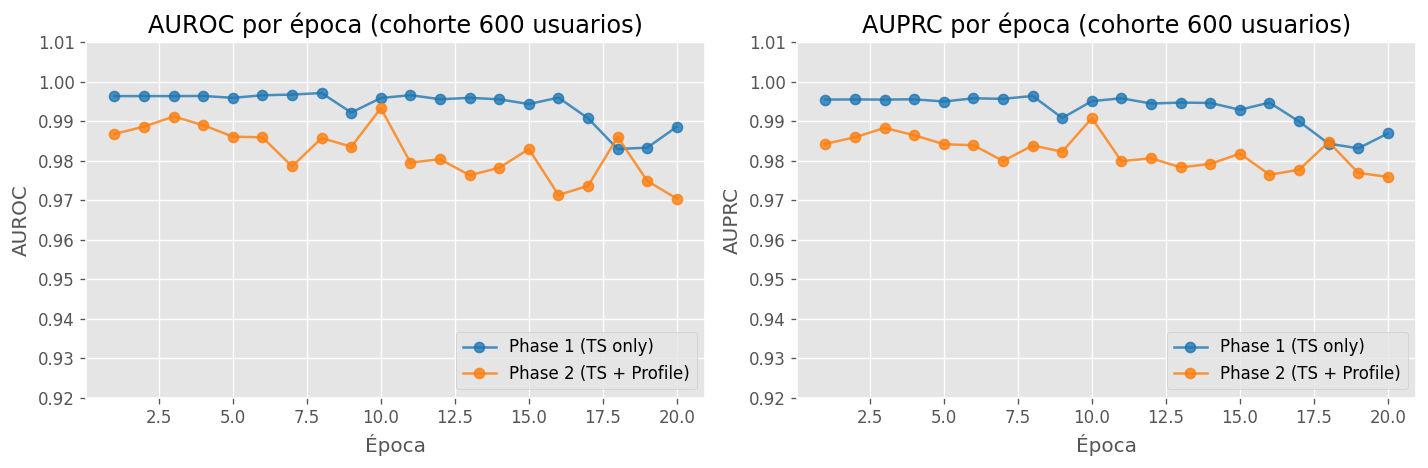

Final AUROC/AUPRC Phase 1: 0.9887/0.9870
Final AUROC/AUPRC Phase 2: 0.9704/0.9759


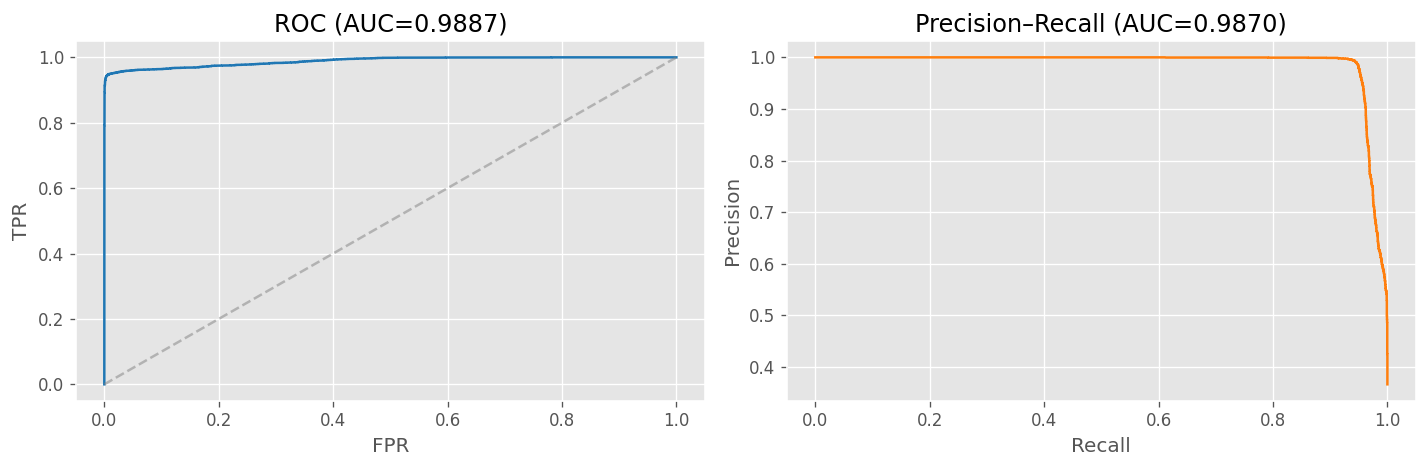

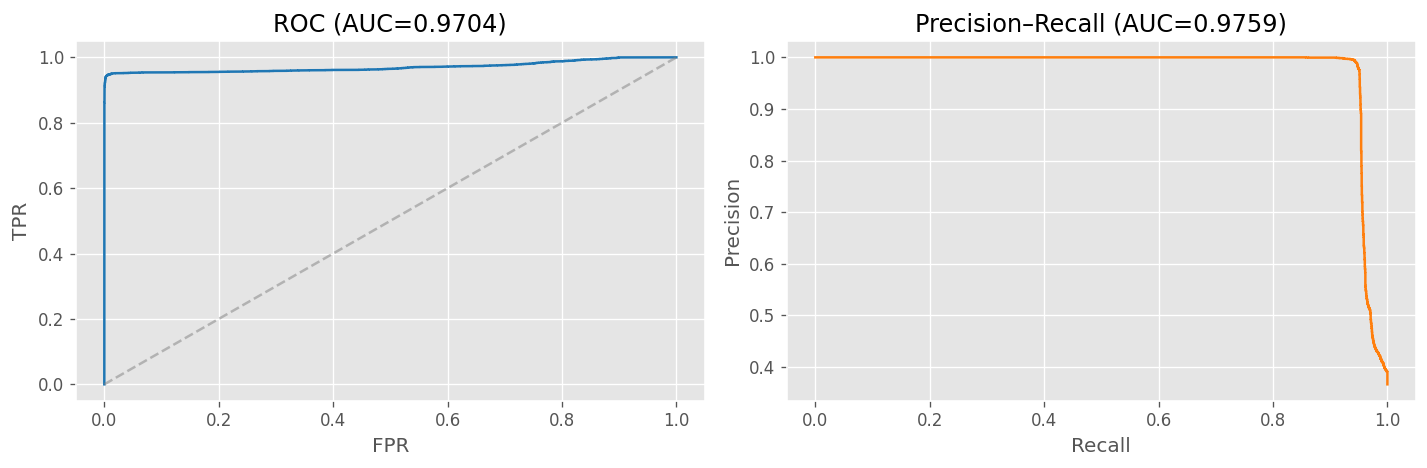

In [18]:
# Curvas por época
plot_epoch_curves(history_p1, history_p2, title_suffix=f"(cohorte {len(set([u for u,_ in meta]))} usuarios)")

# Curvas ROC/PR usando el mejor modelo de cada fase
# Fase 1: recolectar probabilidades finales
def collect_probs_phase1(model, loader):
    ys, ps = [], []
    model.eval()
    with torch.no_grad():
        for Xb, Tb, Mb, yb in loader:
            prob = torch.sigmoid(model.forward_phase1(Xb.to(device), Tb.to(device), Mb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)

def collect_probs_phase2(model, loader):
    ys, ps = [], []
    model.eval()
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase2(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)

y1, p1 = collect_probs_phase1(model_p1, test_loader_p1)
y2, p2 = collect_probs_phase2(model_p2, test_loader_p2)

print(f"Final AUROC/AUPRC Phase 1: {roc_auc_score(y1,p1):.4f}/{average_precision_score(y1,p1):.4f}")
print(f"Final AUROC/AUPRC Phase 2: {roc_auc_score(y2,p2):.4f}/{average_precision_score(y2,p2):.4f}")

plot_roc_pr_curves(y1, p1, title='Phase 1 (TS only)')
plot_roc_pr_curves(y2, p2, title='Phase 2 (TS + Profile)')

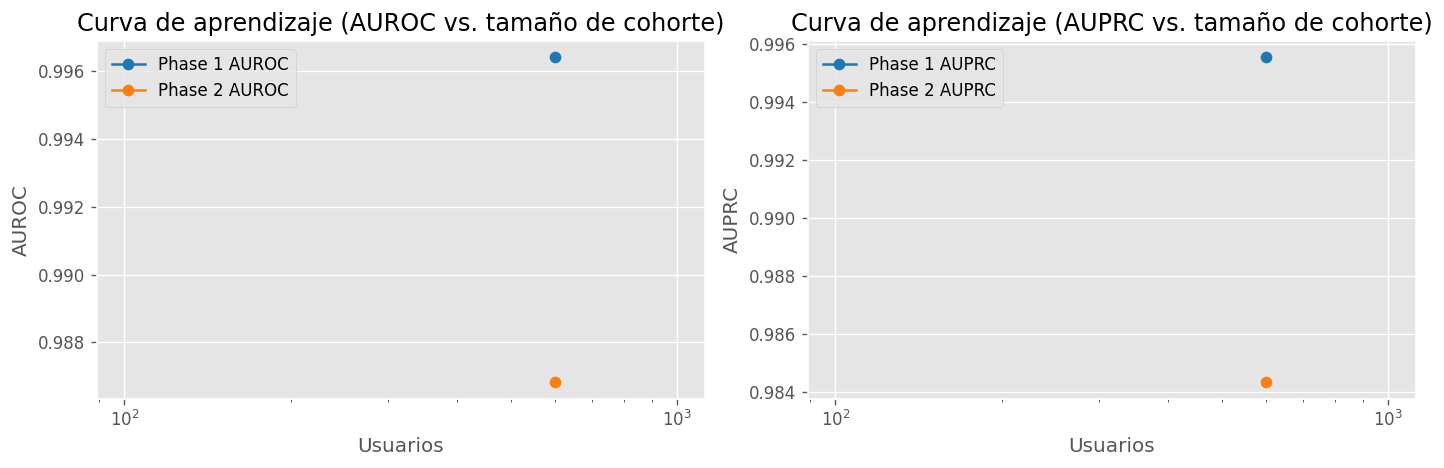

In [19]:
import json
import matplotlib.pyplot as plt

RES_PATH = DATA_DIR / "phase_results_summary.json"
data = json.loads(RES_PATH.read_text())
data = sorted(data, key=lambda x: x['cohort_users'])

sizes = [d['cohort_users'] for d in data]
p1_auroc = [d['phase1']['auroc'] for d in data]
p2_auroc = [d['phase2']['auroc'] for d in data]
p1_auprc = [d['phase1']['auprc'] for d in data]
p2_auprc = [d['phase2']['auprc'] for d in data]

fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)
ax[0].plot(sizes, p1_auroc, marker='o', label='Phase 1 AUROC', color='#1f77b4')
ax[0].plot(sizes, p2_auroc, marker='o', label='Phase 2 AUROC', color='#ff7f0e')
ax[0].set_title('Curva de aprendizaje (AUROC vs. tamaño de cohorte)')
ax[0].set_xlabel('Usuarios'); ax[0].set_ylabel('AUROC'); ax[0].set_xscale('log'); ax[0].legend()

ax[1].plot(sizes, p1_auprc, marker='o', label='Phase 1 AUPRC', color='#1f77b4')
ax[1].plot(sizes, p2_auprc, marker='o', label='Phase 2 AUPRC', color='#ff7f0e')
ax[1].set_title('Curva de aprendizaje (AUPRC vs. tamaño de cohorte)')
ax[1].set_xlabel('Usuarios'); ax[1].set_ylabel('AUPRC'); ax[1].set_xscale('log'); ax[1].legend()

plt.tight_layout(); plt.show()

In [1]:
# ============================
# Configuración y utilidades
# ============================
import os
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import timedelta

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score

# Ruta base → usa la subcarpeta del tamaño de cohorte
BASE_DIR = Path('/home/gmartinez/Tesis/Datasets/Synthetic-data/outputs')
COHORT = '600'  # <-- cambia a '300', '600', '1200', '1500'
DATA_DIR = BASE_DIR / COHORT

HR_CSV = DATA_DIR / "hr_series.csv"
SLEEP_CSV = DATA_DIR / "sleep_series.csv"
LABELS_CSV = DATA_DIR / "nightly_labeled.csv"
PROFILES_CSV = DATA_DIR / "user_profiles.csv"

SEED = 42
def set_seed(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================
# Carga y normalización
# ============================
hr_data = pd.read_csv(HR_CSV, parse_dates=['timestamp'])
sleep_data = pd.read_csv(SLEEP_CSV, parse_dates=['night_date'])
labels = pd.read_csv(LABELS_CSV, parse_dates=['night_date'])
profiles_df = pd.read_csv(PROFILES_CSV)

for df in (hr_data, sleep_data, labels, profiles_df):
    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].astype(str)

# Serie diaria HR
hr_data['date'] = hr_data['timestamp'].dt.floor('D')
hr_daily = (
    hr_data
    .groupby(['user_id','date'], as_index=False)
    .agg(hr_count=('hr','count'),
         hr_med=('hr','median'))
)

# Etiquetas binarizadas
label_map = {'Adequate Recovery': 1, 'Deficient Recovery': 0}
labels['target'] = labels['recovery_label_binary'].map(label_map).astype(int)
nights = labels[['user_id','night_date','target']].dropna().copy()
nights['night_date'] = pd.to_datetime(nights['night_date'])

# ============================
# Features de sueño nocturno
# ============================
SLEEP_FEATURES = [
    'total_hours','deep_minutes','rem_minutes','awake_minutes',
    'sleep_latency_minutes','awakenings','failure_minutes'
]
# Asegura presencia de columnas (si no existen, crea con NaN)
for col in SLEEP_FEATURES:
    if col not in sleep_data.columns:
        sleep_data[col] = np.nan

# ============================
# Extracción de ventanas y muestras
# ============================
def extract_hr_window(hr_daily_user, night_date, past_days=7, include_night=True, feature='hr_count'):
    L = past_days + (1 if include_night else 0)
    start_date = night_date - timedelta(days=past_days)
    end_date = night_date if include_night else (night_date - timedelta(days=1))
    idx_days = pd.date_range(start=start_date, end=end_date, freq='D')
    ser = (
        pd.DataFrame({'date': idx_days})
        .merge(hr_daily_user[['date', feature]], on='date', how='left')
        [feature]
        .to_numpy(dtype=float)
    )
    if len(ser) != L:
        ser = np.resize(ser, L)
    return ser  # deja NaN si faltan

def extract_sleep_features_for_night(sleep_user, night_date, features=SLEEP_FEATURES):
    row = sleep_user.loc[sleep_user['night_date'] == night_date, features]
    if row.empty:
        return np.array([np.nan]*len(features), dtype=float)
    return row.iloc[0].astype(float).to_numpy()

def build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'):
    hr_by_user = {u: df.sort_values('date') for u, df in hr_daily.groupby('user_id')}
    sleep_by_user = {u: df.sort_values('night_date') for u, df in sleep_data.groupby('user_id')}

    X_list, T_list, M_list, y_list, meta_list, night_feat_list = [], [], [], [], [], []

    for _, row in nights.iterrows():
        u = row['user_id']; night = row['night_date']; target = row['target']
        hr_user = hr_by_user.get(u, pd.DataFrame(columns=['date',use_hr_feature]))
        sleep_user = sleep_by_user.get(u, pd.DataFrame(columns=['night_date'] + SLEEP_FEATURES))

        # HR canal 0
        hr_vec = extract_hr_window(hr_user, night_date=night, past_days=past_days,
                                   include_night=True, feature=use_hr_feature)
        L1 = len(hr_vec)
        t_hr = np.linspace(0.0, 1.0, L1)
        m_hr = (~np.isnan(hr_vec)).astype(float)

        # Sleep en último instante
        s_vec = extract_sleep_features_for_night(sleep_user, night, features=SLEEP_FEATURES)
        t_sl = np.array([1.0])
        m_sl = (~np.isnan(s_vec)).astype(float)

        # Secuencia
        t_seq = np.concatenate([t_hr, t_sl], axis=0)  # (L1+1,)
        C = 1 + len(SLEEP_FEATURES)
        X = np.zeros((L1+1, C), dtype=float)
        M = np.zeros((L1+1, C), dtype=float)
        X[:L1, 0] = hr_vec;    M[:L1, 0] = m_hr
        X[L1, 1:] = s_vec;     M[L1, 1:] = m_sl

        X_list.append(X); T_list.append(t_seq); M_list.append(M)
        y_list.append(target); meta_list.append((u, night))
        night_feat_list.append(s_vec)  # para Fase 3

    return X_list, T_list, M_list, np.array(y_list, dtype=int), meta_list, np.vstack(night_feat_list)

X_list, T_list, M_list, y, meta, night_feats = build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count')

# ============================
# Apilado y estandarización por canal
# ============================
def stack_fixed_length(X_list, T_list, M_list):
    X = np.stack(X_list, axis=0)
    T = np.stack(T_list, axis=0)
    M = np.stack(M_list, axis=0)
    return X, T, M

X_all, T_all, M_all = stack_fixed_length(X_list, T_list, M_list)

# Split por usuario
users = np.array([u for u, _ in meta]).astype(str)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(np.zeros(len(users)), groups=users))

# Stats por canal usando solo observados en train
obs_mask = M_all[train_idx].astype(bool)
sum_x = np.nansum(np.where(obs_mask, X_all[train_idx], np.nan), axis=(0,1))
count_x = obs_mask.sum(axis=(0,1)).clip(min=1)
mean_x = sum_x / count_x
sum_sq = np.nansum((np.where(obs_mask, X_all[train_idx], mean_x) - mean_x)**2, axis=(0,1))
var_x = sum_sq / count_x
std_x = np.sqrt(np.maximum(var_x, 1e-8))

def apply_standardize(X, M, mean_x, std_x):
    Xz = (np.where(M>0, X, mean_x) - mean_x) / std_x
    Xz = np.where(M>0, Xz, 0.0)  # puntos ausentes → 0
    return Xz

X_std = apply_standardize(X_all, M_all, mean_x, std_x)

# Split finales
X_train, T_train, M_train, y_train = X_std[train_idx], T_all[train_idx], M_all[train_idx], y[train_idx]
X_test,  T_test,  M_test,  y_test  = X_std[test_idx],  T_all[test_idx],  M_all[test_idx],  y[test_idx]
night_feats_train, night_feats_test = night_feats[train_idx], night_feats[test_idx]

# ============================
# Perfiles (artefactos y matrices)
# ============================
CAT_COLS = ['age_group','gender','physical_activity_level','smoking_status','alcohol_consumption','diabetes','hypertension']
NUM_COLS = ['age']

train_users = sorted(set(users[train_idx]))
test_users  = sorted(set(users[test_idx]))
df_prof_train = profiles_df[profiles_df['user_id'].isin(train_users)].copy()
df_prof_test  = profiles_df[profiles_df['user_id'].isin(test_users)].copy()

def fit_profile_artifacts(df_train, cat_cols, num_cols):
    cat_maps = {}
    for c in cat_cols:
        cats = list(pd.Series(df_train[c].astype(str)).astype('category').cat.categories)
        if "<UNK>" not in cats: cats += ["<UNK>"]
        cat_maps[c] = cats
    num_stats = {}
    for c in num_cols:
        col = pd.to_numeric(df_train[c], errors='coerce')
        mu = float(col.mean(skipna=True)) if col.notna().any() else 0.0
        sd = float(col.std(skipna=True)) if col.notna().any() else 1.0
        if sd < 1e-8: sd = 1.0
        num_stats[c] = {"mean": mu, "std": sd}
    return cat_maps, num_stats

cat_maps, num_stats = fit_profile_artifacts(df_prof_train, CAT_COLS, NUM_COLS)

def one_hot_series(series, categories):
    cat_to_idx = {cat:i for i,cat in enumerate(categories)}
    unk = cat_to_idx.get("<UNK>")
    idx = [cat_to_idx.get(str(v), unk) for v in series.fillna("<UNK>").astype(str)]
    mat = np.eye(len(categories), dtype=np.float32)[np.array(idx, dtype=int)]
    return mat

def zscore_series(series, mean, std):
    x = pd.to_numeric(series, errors='coerce').fillna(mean).to_numpy(dtype=np.float32)
    return ((x - mean) / std).astype(np.float32)

def build_profile_matrix(df):
    parts = []; feature_names = []
    for c in NUM_COLS:
        z = zscore_series(df[c], num_stats[c]['mean'], num_stats[c]['std']).reshape(-1,1)
        parts.append(z); feature_names.append(f"{c}_z")
    for c in CAT_COLS:
        oh = one_hot_series(df[c], cat_maps[c])
        parts.append(oh); feature_names += [f"{c}={v}" for v in cat_maps[c]]
    pres = np.ones((df.shape[0],1), dtype=np.float32)
    parts.append(pres); feature_names.append("profile_present")
    P = np.concatenate(parts, axis=1).astype(np.float32)
    return P, feature_names

P_train, _ = build_profile_matrix(df_prof_train)
P_test,  _ = build_profile_matrix(df_prof_test)
prof_by_user_train = {u: v for u, v in zip(df_prof_train['user_id'].astype(str), list(P_train))}
prof_by_user_test  = {u: v for u, v in zip(df_prof_test['user_id'].astype(str),  list(P_test))}
p_dim = P_train.shape[1]

def build_sample_profiles(meta, train_split_users, prof_train, prof_test, p_dim):
    profiles = []
    for (u, _night) in meta:
        u = str(u)
        vec = prof_train.get(u) if (u in train_split_users) else prof_test.get(u)
        if vec is None:
            v = np.zeros((p_dim,), dtype=np.float32)
            v[-1] = 0.0  # profile_present = 0
            vec = v
        profiles.append(vec.astype(np.float32))
    return np.stack(profiles).astype(np.float32)

train_split_users_set = set(train_users)
profiles_all = build_sample_profiles(meta, train_split_users_set, prof_by_user_train, prof_by_user_test, p_dim)
profiles_train = profiles_all[train_idx]
profiles_test  = profiles_all[test_idx]

# ============================
# Datasets
# ============================
class TimeDataset(Dataset):
    def __init__(self, X, T, M, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.y[idx]

class TimeDatasetWithProfile(Dataset):
    def __init__(self, X, T, M, P, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.y[idx]

class TimeDatasetWithProfileNight(Dataset):
    def __init__(self, X, T, M, P, Nf, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.Nf = torch.tensor(Nf, dtype=torch.float32)  # features nocturnos directos
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.Nf[idx], self.y[idx]

train_loader_p1 = DataLoader(TimeDataset(X_train, T_train, M_train, y_train), batch_size=128, shuffle=True)
test_loader_p1  = DataLoader(TimeDataset(X_test,  T_test,  M_test,  y_test),  batch_size=256, shuffle=False)

train_loader_p2 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True)
test_loader_p2  = DataLoader(TimeDatasetWithProfile(X_test,  T_test,  M_test,  profiles_test,  y_test),  batch_size=256, shuffle=False)

train_loader_p3 = DataLoader(TimeDatasetWithProfileNight(X_train, T_train, M_train, profiles_train, night_feats_train, y_train), batch_size=128, shuffle=True)
test_loader_p3  = DataLoader(TimeDatasetWithProfileNight(X_test,  T_test,  M_test,  profiles_test,  night_feats_test,  y_test),  batch_size=256, shuffle=False)

# ============================
# Modelo mTAN + cabezales
# ============================
class TimeAwareAttention(nn.Module):
    def __init__(self, d_in, d_model, n_heads=4, dropout=0.2):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads
        assert d_model % n_heads == 0
        self.Wq = nn.Linear(d_in, d_model)
        self.Wk = nn.Linear(d_in, d_model)
        self.Wv = nn.Linear(d_in, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.time_decay = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, T, M):
        B, L, Cin = X.shape
        Q = self.Wq(X); K = self.Wk(X); V = self.Wv(X)
        def split(Z): return Z.view(B, L, self.n_heads, self.dk).transpose(1,2)
        Qh, Kh, Vh = split(Q), split(K), split(V)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / np.sqrt(self.dk)
        Ti = T.unsqueeze(1).unsqueeze(-1); Tj = T.unsqueeze(1).unsqueeze(-2)
        dist = torch.abs(Ti - Tj)
        scores = scores - self.time_decay.abs() * dist
        time_mask = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~time_mask, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        Z = torch.matmul(attn, Vh)
        Z = Z.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.out(Z), attn

class MTANBackbone(nn.Module):
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(c_in, d_model)
        self.layers = nn.ModuleList([
            nn.ModuleList([
                TimeAwareAttention(d_model, d_model, n_heads=n_heads, dropout=dropout),
                nn.LayerNorm(d_model),
                nn.Sequential(
                    nn.Linear(d_model, d_model*2),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model*2, d_model)
                ),
                nn.LayerNorm(d_model),
            ]) for _ in range(n_layers)
        ])

    def forward(self, X, T, M):
        x = self.input_proj(X)
        for attn, ln1, ff, ln2 in self.layers:
            h, _ = attn(x, T, M)
            x = ln1(x + h)
            f = ff(x)
            x = ln2(x + f)
        time_mask = (M.sum(dim=-1) > 0).float()
        masked_x = x * time_mask.unsqueeze(-1)
        denom = time_mask.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled = masked_x.sum(dim=1) / denom
        return pooled  # (B, d_model)

class TSOnlyHead(nn.Module):
    def __init__(self, d_model=128, dropout=0.2):
        super().__init__()
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )
    def forward(self, h): return self.cls(h).squeeze(-1)

class ProfileMLP(nn.Module):
    def __init__(self, p_dim, d_hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(p_dim, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, p): return self.net(p)

class NightFeatMLP(nn.Module):
    def __init__(self, nf_dim, d_hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nf_dim, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, n): return self.net(n)

class TSPlusProfileHead(nn.Module):
    def __init__(self, d_model=128, p_hidden=64, d_joint=128, dropout=0.2):
        super().__init__()
        self.joint = nn.Sequential(
            nn.Linear(d_model + p_hidden, d_joint),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_joint, 1)
        )
    def forward(self, h_mtan, h_prof):
        z = torch.cat([h_mtan, h_prof], dim=-1)
        return self.joint(z).squeeze(-1)

class TSPlusProfileNightHead(nn.Module):
    def __init__(self, d_model=128, p_hidden=64, n_hidden=64, d_joint=128, dropout=0.2):
        super().__init__()
        self.joint = nn.Sequential(
            nn.Linear(d_model + p_hidden + n_hidden, d_joint),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_joint, 1)
        )
    def forward(self, h_mtan, h_prof, h_night):
        z = torch.cat([h_mtan, h_prof, h_night], dim=-1)
        return self.joint(z).squeeze(-1)

class MTANWithHeads(nn.Module):
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2,
                 p_dim=None, prof_hidden=64, nf_dim=None, night_hidden=64, dropout=0.2):
        super().__init__()
        self.backbone = MTANBackbone(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout)
        self.ts_head = TSOnlyHead(d_model=d_model, dropout=dropout)
        self.use_profile = p_dim is not None
        self.use_night = nf_dim is not None
        if self.use_profile:
            self.prof_mlp = ProfileMLP(p_dim=p_dim, d_hidden=prof_hidden, dropout=0.1)
            self.ts_p_head = TSPlusProfileHead(d_model=d_model, p_hidden=prof_hidden, d_joint=d_model, dropout=dropout)
        if self.use_profile and self.use_night:
            self.night_mlp = NightFeatMLP(nf_dim=nf_dim, d_hidden=night_hidden, dropout=0.1)
            self.ts_p_n_head = TSPlusProfileNightHead(d_model=d_model, p_hidden=prof_hidden, n_hidden=night_hidden, d_joint=d_model, dropout=dropout)

    def forward_phase1(self, X, T, M):
        h = self.backbone(X, T, M)
        return self.ts_head(h)

    def forward_phase2(self, X, T, M, p):
        h = self.backbone(X, T, M)
        h_p = self.prof_mlp(p)
        return self.ts_p_head(h, h_p)

    def forward_phase3(self, X, T, M, p, nfeat):
        h = self.backbone(X, T, M)
        h_p = self.prof_mlp(p)
        h_n = self.night_mlp(nfeat)
        return self.ts_p_n_head(h, h_p, h_n)

# ============================
# Entrenamiento/Evaluación comunes
# ============================
def evaluate_p1(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, yb in loader:
            Xb, Tb, Mb, yb = Xb.to(device), Tb.to(device), Mb.to(device), yb.to(device)
            prob = torch.sigmoid(model.forward_phase1(Xb, Tb, Mb))
            ys.append(yb.detach().cpu().numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    auroc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    return auroc, auprc

def evaluate_p2(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            Xb, Tb, Mb, Pb, yb = Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device), yb.to(device)
            prob = torch.sigmoid(model.forward_phase2(Xb, Tb, Mb, Pb))
            ys.append(yb.detach().cpu().numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    auroc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    return auroc, auprc

def evaluate_p3(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, Nb, yb in loader:
            Xb, Tb, Mb, Pb, Nb, yb = Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device), Nb.to(device), yb.to(device)
            prob = torch.sigmoid(model.forward_phase3(Xb, Tb, Mb, Pb, Nb))
            ys.append(yb.detach().cpu().numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    auroc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    return auroc, auprc

def train_loop(model, loader, epochs, lr=2e-3, wd=1e-4, phase='p1'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best = {'auroc': -1, 'state': None}
    history = []
    for ep in range(1, epochs+1):
        model.train()
        for batch in loader:
            optimizer.zero_grad()
            if phase == 'p1':
                Xb, Tb, Mb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase1(Xb, Tb, Mb)
            elif phase == 'p2':
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase2(Xb, Tb, Mb, Pb)
            else:  # p3
                Xb, Tb, Mb, Pb, Nb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase3(Xb, Tb, Mb, Pb, Nb)
            loss = criterion(logit, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()
        # Eval por época
        if phase == 'p1':
            auroc, auprc = evaluate_p1(model, test_loader_p1)
        elif phase == 'p2':
            auroc, auprc = evaluate_p2(model, test_loader_p2)
        else:
            auroc, auprc = evaluate_p3(model, test_loader_p3)
        history.append({'epoch': ep, 'auroc': auroc, 'auprc': auprc})
        if auroc > best['auroc']:
            best['auroc'] = auroc
            best['state'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"[{phase.upper()}] Epoch {ep:02d} | Test AUROC {auroc:.4f} | AUPRC {auprc:.4f}")
    # Restaurar mejor estado
    if best['state'] is not None:
        model.load_state_dict(best['state'])
    return model, history, best['auroc']

# ============================
# Entrenar Fases 1, 2 y 3
# ============================
EPOCHS = 20
c_in = X_train.shape[2]
nf_dim = night_feats_train.shape[1]

# Fase 1
set_seed(SEED)
model_p1 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                         p_dim=None, nf_dim=None, dropout=0.2).to(device)
model_p1, hist_p1, best_p1 = train_loop(model_p1, train_loader_p1, epochs=EPOCHS, phase='p1')
auroc_p1, auprc_p1 = evaluate_p1(model_p1, test_loader_p1)

# Fase 2
set_seed(SEED)
model_p2 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                         p_dim=p_dim, nf_dim=None, dropout=0.2).to(device)
model_p2, hist_p2, best_p2 = train_loop(model_p2, train_loader_p2, epochs=EPOCHS, phase='p2')
auroc_p2, auprc_p2 = evaluate_p2(model_p2, test_loader_p2)

# Fase 3 (TS + Perfil + Features nocturnos directos)
set_seed(SEED)
model_p3 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                         p_dim=p_dim, nf_dim=nf_dim, dropout=0.2).to(device)

model_p3, hist_p3, _ = train_loop(model_p3, train_loader_p3, lambda m: 
                                  evaluate_p3(m, test_loader_p3), epochs=EPOCHS, phase_tag='P3')

#model_p3, hist_p3, best_p3 = train_loop(model_p3, train_loader_p3, epochs=EPOCHS, phase='p3')
#auroc_p3, auprc_p3 = evaluate_p3(model_p3, test_loader_p3)

# ============================
# Resultados y registro
# ============================
print(f"===== Final Results (cohort {COHORT}) =====")
print(f"Phase 1 (TS only)          -> AUROC: {auroc_p1:.4f} | AUPRC: {auprc_p1:.4f}")
print(f"Phase 2 (TS + Profile)      -> AUROC: {auroc_p2:.4f} | AUPRC: {auprc_p2:.4f}")
print(f"Phase 3 (TS + Profile + NF) -> AUROC: {auroc_p3:.4f} | AUPRC: {auprc_p3:.4f}")

# Guardar resumen por cohorte
import json
RES_PATH = BASE_DIR / "phase_results_summary.json"
summary_item = {
    "cohort_users": int(COHORT),
    "phase1": {"auroc": float(auroc_p1), "auprc": float(auprc_p1)},
    "phase2": {"auroc": float(auroc_p2), "auprc": float(auprc_p2)},
    "phase3": {"auroc": float(auroc_p3), "auprc": float(auprc_p3)}
}
try:
    existing = json.loads(RES_PATH.read_text())
except Exception:
    existing = []
existing.append(summary_item)
RES_PATH.write_text(json.dumps(existing, indent=2))


[P1] Epoch 01 | Test AUROC 0.9848 | AUPRC 0.9845
[P1] Epoch 02 | Test AUROC 0.9890 | AUPRC 0.9884
[P1] Epoch 03 | Test AUROC 0.9888 | AUPRC 0.9887
[P1] Epoch 04 | Test AUROC 0.9845 | AUPRC 0.9874
[P1] Epoch 05 | Test AUROC 0.9846 | AUPRC 0.9864
[P1] Epoch 06 | Test AUROC 0.9840 | AUPRC 0.9864
[P1] Epoch 07 | Test AUROC 0.9846 | AUPRC 0.9869
[P1] Epoch 08 | Test AUROC 0.9859 | AUPRC 0.9872
[P1] Epoch 09 | Test AUROC 0.9872 | AUPRC 0.9885
[P1] Epoch 10 | Test AUROC 0.9856 | AUPRC 0.9877
[P1] Epoch 11 | Test AUROC 0.9846 | AUPRC 0.9876
[P1] Epoch 12 | Test AUROC 0.9914 | AUPRC 0.9912
[P1] Epoch 13 | Test AUROC 0.9861 | AUPRC 0.9885
[P1] Epoch 14 | Test AUROC 0.9882 | AUPRC 0.9896
[P1] Epoch 15 | Test AUROC 0.9869 | AUPRC 0.9891
[P1] Epoch 16 | Test AUROC 0.9863 | AUPRC 0.9886
[P1] Epoch 17 | Test AUROC 0.9869 | AUPRC 0.9891
[P1] Epoch 18 | Test AUROC 0.9873 | AUPRC 0.9892
[P1] Epoch 19 | Test AUROC 0.9865 | AUPRC 0.9889
[P1] Epoch 20 | Test AUROC 0.9864 | AUPRC 0.9888
[P2] Epoch 01 | Test

528

In [12]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from datetime import timedelta

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [14]:
# Acceso a archivos y definición de constantes

BASE_DIR = Path('/home/gmartinez/Tesis/Datasets/Synthetic-data')
OUTPUTS_DIR = BASE_DIR / 'outputs'  # raíz con subcarpetas: 300, 600, 1200, 1500
COHORTS = ['300', '600', '1200', '1500']
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=SEED):
    import random
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [15]:
class TimeAwareAttention(nn.Module):
    def __init__(self, d_in, d_model, n_heads=4, dropout=0.2):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads
        assert d_model % n_heads == 0
        self.Wq = nn.Linear(d_in, d_model)
        self.Wk = nn.Linear(d_in, d_model)
        self.Wv = nn.Linear(d_in, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.time_decay = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, T, M):
        B, L, Cin = X.shape
        Q = self.Wq(X); K = self.Wk(X); V = self.Wv(X)
        def split(Z): return Z.view(B, L, self.n_heads, self.dk).transpose(1,2)
        Qh, Kh, Vh = split(Q), split(K), split(V)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / (self.dk ** 0.5)
        Ti = T.unsqueeze(1).unsqueeze(-1); Tj = T.unsqueeze(1).unsqueeze(-2)
        dist = torch.abs(Ti - Tj)
        scores = scores - self.time_decay.abs() * dist
        time_mask = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~time_mask, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        Z = torch.matmul(attn, Vh)
        Z = Z.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.out(Z), attn

class FiLMGenerator(nn.Module):
    """
    Genera (gamma, beta) por capa a partir del embedding de perfil.
    - p_dim: dimensión del perfil
    - d_model: dimensión del backbone
    - n_layers: número de capas que se van a modular
    """
    def __init__(self, p_dim, d_model, n_layers, hidden=64, dropout=0.1):
        super().__init__()
        self.n_layers = n_layers
        # Un MLP que produce gamma y beta concatenados para cada capa
        out_dim = n_layers * d_model * 2
        self.mlp = nn.Sequential(
            nn.Linear(p_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )

    def forward(self, p):
        """
        p: (B, p_dim)
        devuelve:
          gamma: (B, n_layers, d_model)
          beta : (B, n_layers, d_model)
        """
        B = p.shape[0]
        out = self.mlp(p)  # (B, n_layers*d_model*2)
        out = out.view(B, self.n_layers, 2, -1)  # (B, n_layers, 2, d_model)
        gamma = out[:, :, 0, :]  # (B, n_layers, d_model)
        beta  = out[:, :, 1, :]  # (B, n_layers, d_model)
        return gamma, beta

class MTANBackboneFiLM(nn.Module):
    """
    Backbone mTAN que acepta condición de perfil p y aplica FiLM por capa.
    Si cond=None, actúa como el backbone original.
    """
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2, dropout=0.2, p_dim=None, film_hidden=64):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.input_proj = nn.Linear(c_in, d_model)
        self.layers = nn.ModuleList([
            nn.ModuleList([
                TimeAwareAttention(d_model, d_model, n_heads=n_heads, dropout=dropout),
                nn.LayerNorm(d_model),
                nn.Sequential(
                    nn.Linear(d_model, d_model*2),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model*2, d_model)
                ),
                nn.LayerNorm(d_model),
            ]) for _ in range(n_layers)
        ])
        self.use_film = p_dim is not None
        if self.use_film:
            self.film = FiLMGenerator(p_dim=p_dim, d_model=d_model, n_layers=n_layers, hidden=film_hidden, dropout=0.1)

    def forward(self, X, T, M, cond=None):
        """
        X: (B,L,C), T:(B,L), M:(B,L,C)
        cond: (B, p_dim) embedding de perfil
        """
        x = self.input_proj(X)  # (B, L, d_model)
        gamma = beta = None
        if self.use_film and cond is not None:
            gamma, beta = self.film(cond)  # (B, n_layers, d_model)
        for li, (attn, ln1, ff, ln2) in enumerate(self.layers):
            h, _ = attn(x, T, M)          # atención
            x = ln1(x + h)                # residual + LN
            # FiLM tras atención
            if gamma is not None and beta is not None:
                # broadcast a (B,L,d_model)
                g = gamma[:, li, :].unsqueeze(1)  # (B,1,d_model)
                b = beta[:,  li, :].unsqueeze(1)  # (B,1,d_model)
                x = g * x + b

            f = ff(x)                     # feed-forward
            x = ln2(x + f)                # residual + LN
            # FiLM tras FF
            if gamma is not None and beta is not None:
                g = gamma[:, li, :].unsqueeze(1)
                b = beta[:,  li, :].unsqueeze(1)
                x = g * x + b

        # Pooling temporal con máscara
        time_mask = (M.sum(dim=-1) > 0).float()
        masked_x = x * time_mask.unsqueeze(-1)
        denom = time_mask.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled = masked_x.sum(dim=1) / denom
        return pooled  # (B, d_model)

class TSOnlyHead(nn.Module):
    def __init__(self, d_model=128, dropout=0.2):
        super().__init__()
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )
    def forward(self, h): return self.cls(h).squeeze(-1)

class ProfileMLP(nn.Module):
    def __init__(self, p_dim, d_hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(p_dim, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, p): return self.net(p)

class TSPlusProfileHead(nn.Module):
    def __init__(self, d_model=128, p_hidden=64, d_joint=128, dropout=0.2):
        super().__init__()
        self.joint = nn.Sequential(
            nn.Linear(d_model + p_hidden, d_joint),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_joint, 1)
        )
    def forward(self, h_mtan, h_prof): 
        return self.joint(torch.cat([h_mtan, h_prof], dim=-1)).squeeze(-1)

class MTANWithFiLMHeads(nn.Module):
    """
    - Fase 1: solo TS
    - Fase 2: TS + perfil por concatenación post-backbone (como antes)
    - Fase 3: TS con FiLM condicionado por perfil (el perfil modula el backbone)
    """
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2,
                 p_dim=None, prof_hidden=64, film_hidden=64, dropout=0.2):
        super().__init__()
        # Backbone sin FiLM (para Fase 1/2)
        self.backbone_plain = MTANBackboneFiLM(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, p_dim=None)
        # Backbone con FiLM (para Fase 3)
        self.backbone_film  = MTANBackboneFiLM(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, p_dim=p_dim, film_hidden=film_hidden)

        self.ts_head = TSOnlyHead(d_model=d_model, dropout=dropout)
        self.use_profile = p_dim is not None
        if self.use_profile:
            self.prof_mlp = ProfileMLP(p_dim=p_dim, d_hidden=prof_hidden, dropout=0.1)
            self.ts_p_head = TSPlusProfileHead(d_model=d_model, p_hidden=prof_hidden, d_joint=d_model, dropout=dropout)

    # Fase 1: TS only
    def forward_phase1(self, X, T, M):
        h = self.backbone_plain(X, T, M, cond=None)
        return self.ts_head(h)

    # Fase 2: TS + Profile (post-backbone concatenation)
    def forward_phase2(self, X, T, M, p):
        h = self.backbone_plain(X, T, M, cond=None)
        h_p = self.prof_mlp(p)
        return self.ts_p_head(h, h_p)

    # Fase 3: TS con FiLM (perfil condiciona las capas internas)
    def forward_phase3(self, X, T, M, p):
        h_p_raw = p  # vector de perfil crudo
        h = self.backbone_film(X, T, M, cond=h_p_raw)
        # En Fase 3 con FiLM, no concatenamos perfil en la cabeza: ya moduló el backbone
        return self.ts_head(h).squeeze(-1)

# ============================
# Entrenamiento por fase
# ============================
def train_loop(model, loader, eval_fn, epochs=20, lr=2e-3, wd=1e-4, phase_tag='P'):
    import torch.nn.functional as F
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best = {'auroc': -1, 'state': None}; history = []
    for ep in range(1, epochs+1):
        model.train()
        for batch in loader:
            optimizer.zero_grad()
            if phase_tag == 'P1':
                Xb, Tb, Mb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase1(Xb, Tb, Mb)
            elif phase_tag == 'P2':
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase2(Xb, Tb, Mb, Pb)
            else:  # P3-FILM
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase3(Xb, Tb, Mb, Pb)
            loss = criterion(logit, yb); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()
        auroc, auprc = eval_fn(model)
        history.append({'epoch': ep, 'auroc': auroc, 'auprc': auprc})
        if auroc > best['auroc']:
            best['auroc'] = auroc
            best['state'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"[{phase_tag}] Epoch {ep:02d} | AUROC {auroc:.4f} | AUPRC {auprc:.4f}")
    if best['state'] is not None:
        model.load_state_dict(best['state'])
    return model, history, best['auroc']


In [17]:
# ============================
# Utilidades de datos
# ============================
SLEEP_FEATURES = [
    'total_hours','deep_minutes','rem_minutes','awake_minutes',
    'sleep_latency_minutes','awakenings','failure_minutes'
]

def extract_hr_window(hr_daily_user, night_date, past_days=7, include_night=True, feature='hr_count'):
    L = past_days + (1 if include_night else 0)
    start_date = night_date - timedelta(days=past_days)
    end_date = night_date if include_night else (night_date - timedelta(days=1))
    idx_days = pd.date_range(start=start_date, end=end_date, freq='D')
    ser = (
        pd.DataFrame({'date': idx_days})
        .merge(hr_daily_user[['date', feature]], on='date', how='left')
        [feature].to_numpy(dtype=float)
    )
    if len(ser) != L:
        ser = np.resize(ser, L)
    return ser

def extract_sleep_features_for_night(sleep_user, night_date):
    row = sleep_user.loc[sleep_user['night_date'] == night_date, SLEEP_FEATURES]
    if row.empty:
        return np.array([np.nan]*len(SLEEP_FEATURES), dtype=float)
    return row.iloc[0].astype(float).to_numpy()

def build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'):
    hr_by_user = {u: df.sort_values('date') for u, df in hr_daily.groupby('user_id')}
    sleep_by_user = {u: df.sort_values('night_date') for u, df in sleep_data.groupby('user_id')}
    X_list, T_list, M_list, y_list, meta_list, night_feat_list = [], [], [], [], [], []
    for _, row in nights.iterrows():
        u = row['user_id']; night = row['night_date']; target = row['target']
        hr_user = hr_by_user.get(u, pd.DataFrame(columns=['date',use_hr_feature]))
        sleep_user = sleep_by_user.get(u, pd.DataFrame(columns=['night_date'] + SLEEP_FEATURES))
        hr_vec = extract_hr_window(hr_user, night_date=night, past_days=past_days, include_night=True, feature=use_hr_feature)
        L1 = len(hr_vec)
        t_hr = np.linspace(0.0, 1.0, L1); m_hr = (~np.isnan(hr_vec)).astype(float)
        s_vec = extract_sleep_features_for_night(sleep_user, night)
        t_sl = np.array([1.0]); m_sl = (~np.isnan(s_vec)).astype(float)
        t_seq = np.concatenate([t_hr, t_sl], axis=0)
        C = 1 + len(SLEEP_FEATURES)
        X = np.zeros((L1+1, C), dtype=float)
        M = np.zeros((L1+1, C), dtype=float)
        X[:L1, 0] = hr_vec; M[:L1, 0] = m_hr
        X[L1, 1:] = s_vec;  M[L1, 1:] = m_sl
        X_list.append(X); T_list.append(t_seq); M_list.append(M)
        y_list.append(target); meta_list.append((u, night)); night_feat_list.append(s_vec)
    return X_list, T_list, M_list, np.array(y_list, dtype=int), meta_list, np.vstack(night_feat_list)

def stack_fixed_length(X_list, T_list, M_list):
    return np.stack(X_list, axis=0), np.stack(T_list, axis=0), np.stack(M_list, axis=0)

def standardize_by_train(X_all, M_all, train_idx):
    obs_mask = M_all[train_idx].astype(bool)
    sum_x = np.nansum(np.where(obs_mask, X_all[train_idx], np.nan), axis=(0,1))
    count_x = obs_mask.sum(axis=(0,1)).clip(min=1)
    mean_x = sum_x / count_x
    sum_sq = np.nansum((np.where(obs_mask, X_all[train_idx], mean_x) - mean_x)**2, axis=(0,1))
    var_x = sum_sq / count_x
    std_x = np.sqrt(np.maximum(var_x, 1e-8))
    def apply(X, M): 
        Xz = (np.where(M>0, X, mean_x) - mean_x) / std_x
        return np.where(M>0, Xz, 0.0)
    return apply

# Perfiles
CAT_COLS = ['age_group','gender','physical_activity_level','smoking_status','alcohol_consumption','diabetes','hypertension']
NUM_COLS = ['age']

def fit_profile_artifacts(df_train):
    cat_maps = {}
    for c in CAT_COLS:
        cats = list(pd.Series(df_train[c].astype(str)).astype('category').cat.categories)
        if "<UNK>" not in cats: cats += ["<UNK>"]
        cat_maps[c] = cats
    num_stats = {}
    for c in NUM_COLS:
        col = pd.to_numeric(df_train[c], errors='coerce')
        mu = float(col.mean(skipna=True)) if col.notna().any() else 0.0
        sd = float(col.std(skipna=True)) if col.notna().any() else 1.0
        if sd < 1e-8: sd = 1.0
        num_stats[c] = {"mean": mu, "std": sd}
    return cat_maps, num_stats

def one_hot_series(series, categories):
    cat_to_idx = {cat:i for i,cat in enumerate(categories)}
    unk = cat_to_idx.get("<UNK>")
    idx = [cat_to_idx.get(str(v), unk) for v in series.fillna("<UNK>").astype(str)]
    return np.eye(len(categories), dtype=np.float32)[np.array(idx, dtype=int)]

def zscore_series(series, mean, std):
    x = pd.to_numeric(series, errors='coerce').fillna(mean).to_numpy(dtype=np.float32)
    return ((x - mean) / std).astype(np.float32)

def build_profile_matrix(df, cat_maps, num_stats):
    parts = []
    for c in NUM_COLS:
        parts.append(zscore_series(df[c], num_stats[c]['mean'], num_stats[c]['std']).reshape(-1,1))
    for c in CAT_COLS:
        parts.append(one_hot_series(df[c], cat_maps[c]))
    pres = np.ones((df.shape[0],1), dtype=np.float32)
    parts.append(pres)
    P = np.concatenate(parts, axis=1).astype(np.float32)
    return P

# Datasets
class TimeDataset(Dataset):
    def __init__(self, X, T, M, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.y[idx]

class TimeDatasetWithProfile(Dataset):
    def __init__(self, X, T, M, P, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.y[idx]

class TimeDatasetWithProfileNight(Dataset):
    def __init__(self, X, T, M, P, Nf, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.Nf = torch.tensor(Nf, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.Nf[idx], self.y[idx]

# Evaluación
def evaluate_p1(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, yb in loader:
            prob = torch.sigmoid(model.forward_phase1(Xb.to(device), Tb.to(device), Mb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p2(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase2(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p3(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase3(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    auroc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    return auroc, auprc

def train_loop(model, loader, test_eval_fn, epochs=20, lr=2e-3, wd=1e-4, phase_tag='P'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best = {'auroc': -1, 'state': None}; history = []
    for ep in range(1, epochs+1):
        model.train()
        for batch in loader:
            optimizer.zero_grad()
            if phase_tag == 'P1':
                Xb, Tb, Mb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase1(Xb, Tb, Mb)
            elif phase_tag == 'P2':
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase2(Xb, Tb, Mb, Pb)
            else:
                Xb, Tb, Mb, Pb, Nb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase3(Xb, Tb, Mb, Pb, Nb)
            loss = criterion(logit, yb); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()
        auroc, auprc = test_eval_fn(model)
        history.append({'epoch': ep, 'auroc': auroc, 'auprc': auprc})
        if auroc > best['auroc']:
            best['auroc'] = auroc
            best['state'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"[{phase_tag}] Epoch {ep:02d} | AUROC {auroc:.4f} | AUPRC {auprc:.4f}")
    if best['state'] is not None:
        model.load_state_dict(best['state'])
    return model, history, best['auroc']

In [18]:
# ============================
# Bucle multi-cohorte
# ============================
summary_path = OUTPUTS_DIR / "phase_results_summary.json"
try:
    summary = json.loads(summary_path.read_text())
except Exception:
    summary = []

all_histories = {}  # para almacenar curvas por época por cohorte

for cohort in COHORTS:
    print(f"\n==== Procesando cohorte {cohort} ====")
    data_dir = OUTPUTS_DIR / cohort
    hr_csv = data_dir / "hr_series.csv"
    sleep_csv = data_dir / "sleep_series.csv"
    labels_csv = data_dir / "nightly_labeled.csv"
    profiles_csv = data_dir / "user_profiles.csv"

    # Validación rápida
    for p in [hr_csv, sleep_csv, labels_csv, profiles_csv]:
        if not p.exists():
            print(f"Saltando cohorte {cohort}: falta {p.name}")
            break
    else:
        # Cargar
        hr_data = pd.read_csv(hr_csv, parse_dates=['timestamp'])
        sleep_data = pd.read_csv(sleep_csv, parse_dates=['night_date'])
        labels = pd.read_csv(labels_csv, parse_dates=['night_date'])
        profiles_df = pd.read_csv(profiles_csv)

        for df in (hr_data, sleep_data, labels, profiles_df):
            if 'user_id' in df.columns:
                df['user_id'] = df['user_id'].astype(str)

        # Serie diaria
        hr_data['date'] = hr_data['timestamp'].dt.floor('D')
        hr_daily = (
            hr_data
            .groupby(['user_id','date'], as_index=False)
            .agg(hr_count=('hr','count'),
                 hr_med=('hr','median'))
        )

        # Etiquetas
        label_map = {'Adequate Recovery': 1, 'Deficient Recovery': 0}
        labels['target'] = labels['recovery_label_binary'].map(label_map).astype(int)
        nights = labels[['user_id','night_date','target']].dropna().copy()
        nights['night_date'] = pd.to_datetime(nights['night_date'])

        # Asegurar columnas de sueño
        for col in SLEEP_FEATURES:
            if col not in sleep_data.columns:
                sleep_data[col] = np.nan

        # Construir muestras
        X_list, T_list, M_list, y, meta, night_feats = build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count')
        X_all, T_all, M_all = stack_fixed_length(X_list, T_list, M_list)

        # Split por usuario
        users = np.array([u for u, _ in meta]).astype(str)
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        train_idx, test_idx = next(gss.split(np.zeros(len(users)), groups=users))

        # Estandarizar
        apply_std = standardize_by_train(X_all, M_all, train_idx)
        X_std = apply_std(X_all, M_all)
        X_train, T_train, M_train, y_train = X_std[train_idx], T_all[train_idx], M_all[train_idx], y[train_idx]
        X_test,  T_test,  M_test,  y_test  = X_std[test_idx],  T_all[test_idx],  M_all[test_idx],  y[test_idx]
        night_feats_train, night_feats_test = night_feats[train_idx], night_feats[test_idx]

        # Perfiles
        train_users = sorted(set(users[train_idx]))
        test_users  = sorted(set(users[test_idx]))
        df_prof_train = profiles_df[profiles_df['user_id'].isin(train_users)].copy()
        df_prof_test  = profiles_df[profiles_df['user_id'].isin(test_users)].copy()
        cat_maps, num_stats = fit_profile_artifacts(df_prof_train)

        def build_P(df): return build_profile_matrix(df, cat_maps, num_stats)
        P_train = build_P(df_prof_train); P_test = build_P(df_prof_test)
        prof_by_user_train = {u: v for u, v in zip(df_prof_train['user_id'].astype(str), list(P_train))}
        prof_by_user_test  = {u: v for u, v in zip(df_prof_test['user_id'].astype(str),  list(P_test))}
        p_dim = P_train.shape[1]

        def build_sample_profiles(meta, train_split_users, prof_train, prof_test, p_dim):
            profiles = []
            for (u, _night) in meta:
                u = str(u)
                vec = prof_train.get(u) if (u in train_split_users) else prof_test.get(u)
                if vec is None:
                    v = np.zeros((p_dim,), dtype=np.float32); v[-1] = 0.0
                    vec = v
                profiles.append(vec.astype(np.float32))
            return np.stack(profiles).astype(np.float32)

        train_split_users_set = set(train_users)
        profiles_all = build_sample_profiles(meta, train_split_users_set, prof_by_user_train, prof_by_user_test, p_dim)
        profiles_train = profiles_all[train_idx]; profiles_test = profiles_all[test_idx]

        # Loaders
        train_loader_p1 = DataLoader(TimeDataset(X_train, T_train, M_train, y_train), batch_size=128, shuffle=True)
        test_loader_p1  = DataLoader(TimeDataset(X_test,  T_test,  M_test,  y_test),  batch_size=256, shuffle=False)

        train_loader_p2 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True)
        test_loader_p2  = DataLoader(TimeDatasetWithProfile(X_test,  T_test,  M_test,  profiles_test,  y_test),  batch_size=256, shuffle=False)

        train_loader_p3 = DataLoader(TimeDatasetWithProfileNight(X_train, T_train, M_train, profiles_train, night_feats_train, y_train), batch_size=128, shuffle=True)
        test_loader_p3  = DataLoader(TimeDatasetWithProfileNight(X_test,  T_test,  M_test,  profiles_test,  night_feats_test,  y_test),  batch_size=256, shuffle=False)

        # Modelos y entrenamiento por fase
        EPOCHS = 20
        c_in = X_train.shape[2]
        nf_dim = night_feats_train.shape[1]

        # Fase 1
        set_seed(SEED)
        model_p1 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2, p_dim=None, nf_dim=None, dropout=0.2).to(device)
        model_p1, hist_p1, _ = train_loop(model_p1, train_loader_p1, lambda m: evaluate_p1(m, test_loader_p1), epochs=EPOCHS, phase_tag='P1')
        auroc_p1, auprc_p1 = evaluate_p1(model_p1, test_loader_p1)

        # Fase 2
        set_seed(SEED)
        model_p2 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2, p_dim=p_dim, nf_dim=None, dropout=0.2).to(device)
        model_p2, hist_p2, _ = train_loop(model_p2, train_loader_p2, lambda m: evaluate_p2(m, test_loader_p2), epochs=EPOCHS, phase_tag='P2')
        auroc_p2, auprc_p2 = evaluate_p2(model_p2, test_loader_p2)

        # Fase 3
        set_seed(SEED)
        model_p3 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2, p_dim=p_dim, nf_dim=nf_dim, dropout=0.2).to(device)
        model_p3, hist_p3, _ = train_loop(model_p3, train_loader_p3, lambda m: evaluate_p3(m, test_loader_p3), epochs=EPOCHS, phase_tag='P3')
        auroc_p3, auprc_p3 = evaluate_p3(model_p3, test_loader_p3)

        # Guardar resumen acumulado
        item = {
            "cohort_users": int(cohort),
            "phase1": {"auroc": float(auroc_p1), "auprc": float(auprc_p1)},
            "phase2": {"auroc": float(auroc_p2), "auprc": float(auprc_p2)},
            "phase3": {"auroc": float(auroc_p3), "auprc": float(auprc_p3)}
        }
        summary.append(item)
        summary_path.write_text(json.dumps(summary, indent=2))

        # Guardar historiales por época (opcional, para gráficas de convergencia)
        all_histories[cohort] = {
            "p1": hist_p1,
            "p2": hist_p2,
            "p3": hist_p3
        }


==== Procesando cohorte 300 ====
[P1] Epoch 01 | AUROC 0.9707 | AUPRC 0.9649
[P1] Epoch 02 | AUROC 0.9657 | AUPRC 0.9655
[P1] Epoch 03 | AUROC 0.9682 | AUPRC 0.9665
[P1] Epoch 04 | AUROC 0.9569 | AUPRC 0.9621
[P1] Epoch 05 | AUROC 0.9553 | AUPRC 0.9603
[P1] Epoch 06 | AUROC 0.9724 | AUPRC 0.9702
[P1] Epoch 07 | AUROC 0.9659 | AUPRC 0.9654
[P1] Epoch 08 | AUROC 0.9598 | AUPRC 0.9629
[P1] Epoch 09 | AUROC 0.9586 | AUPRC 0.9626
[P1] Epoch 10 | AUROC 0.9575 | AUPRC 0.9625
[P1] Epoch 11 | AUROC 0.9607 | AUPRC 0.9639
[P1] Epoch 12 | AUROC 0.9594 | AUPRC 0.9630
[P1] Epoch 13 | AUROC 0.9592 | AUPRC 0.9628
[P1] Epoch 14 | AUROC 0.9591 | AUPRC 0.9630
[P1] Epoch 15 | AUROC 0.9575 | AUPRC 0.9623
[P1] Epoch 16 | AUROC 0.9584 | AUPRC 0.9627
[P1] Epoch 17 | AUROC 0.9578 | AUPRC 0.9624
[P1] Epoch 18 | AUROC 0.9585 | AUPRC 0.9626
[P1] Epoch 19 | AUROC 0.9584 | AUPRC 0.9626
[P1] Epoch 20 | AUROC 0.9585 | AUPRC 0.9626
[P2] Epoch 01 | AUROC 0.9751 | AUPRC 0.9706
[P2] Epoch 02 | AUROC 0.9715 | AUPRC 0.967

ValueError: too many values to unpack (expected 5)

In [6]:

class TimeAwareAttention(nn.Module):
    def __init__(self, d_in, d_model, n_heads=4, dropout=0.2):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads
        assert d_model % n_heads == 0
        self.Wq = nn.Linear(d_in, d_model)
        self.Wk = nn.Linear(d_in, d_model)
        self.Wv = nn.Linear(d_in, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.time_decay = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, T, M):
        B, L, Cin = X.shape
        Q = self.Wq(X); K = self.Wk(X); V = self.Wv(X)
        def split(Z): return Z.view(B, L, self.n_heads, self.dk).transpose(1,2)
        Qh, Kh, Vh = split(Q), split(K), split(V)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / (self.dk ** 0.5)
        Ti = T.unsqueeze(1).unsqueeze(-1); Tj = T.unsqueeze(1).unsqueeze(-2)
        dist = torch.abs(Ti - Tj)
        scores = scores - self.time_decay.abs() * dist
        time_mask = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~time_mask, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        Z = torch.matmul(attn, Vh)
        Z = Z.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.out(Z), attn
    






class MTANBackbone(nn.Module):
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(c_in, d_model)
        self.layers = nn.ModuleList([
            nn.ModuleList([
                TimeAwareAttention(d_model, d_model, n_heads=n_heads, dropout=dropout),
                nn.LayerNorm(d_model),
                nn.Sequential(
                    nn.Linear(d_model, d_model*2),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model*2, d_model)
                ),
                nn.LayerNorm(d_model),
            ]) for _ in range(n_layers)
        ])
    def forward(self, X, T, M):
        x = self.input_proj(X)
        for attn, ln1, ff, ln2 in self.layers:
            h, _ = attn(x, T, M)
            x = ln1(x + h)
            f = ff(x)
            x = ln2(x + f)
        time_mask = (M.sum(dim=-1) > 0).float()
        masked_x = x * time_mask.unsqueeze(-1)
        denom = time_mask.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled = masked_x.sum(dim=1) / denom
        return pooled

class TSOnlyHead(nn.Module):
    def __init__(self, d_model=128, dropout=0.2):
        super().__init__()
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )
    def forward(self, h): return self.cls(h).squeeze(-1)

class ProfileMLP(nn.Module):
    def __init__(self, p_dim, d_hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(p_dim, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, p): return self.net(p)

class NightFeatMLP(nn.Module):
    def __init__(self, nf_dim, d_hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nf_dim, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, n): return self.net(n)

class TSPlusProfileHead(nn.Module):
    def __init__(self, d_model=128, p_hidden=64, d_joint=128, dropout=0.2):
        super().__init__()
        self.joint = nn.Sequential(
            nn.Linear(d_model + p_hidden, d_joint),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_joint, 1)
        )
    def forward(self, h_mtan, h_prof):
        return self.joint(torch.cat([h_mtan, h_prof], dim=-1)).squeeze(-1)

class TSPlusProfileNightHead(nn.Module):
    def __init__(self, d_model=128, p_hidden=64, n_hidden=64, d_joint=128, dropout=0.2):
        super().__init__()
        self.joint = nn.Sequential(
            nn.Linear(d_model + p_hidden + n_hidden, d_joint),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_joint, 1)
        )
    def forward(self, h_mtan, h_prof, h_night):
        return self.joint(torch.cat([h_mtan, h_prof, h_night], dim=-1)).squeeze(-1)

class MTANWithHeads(nn.Module):
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2,
                 p_dim=None, prof_hidden=64, nf_dim=None, night_hidden=64, dropout=0.2):
        super().__init__()
        self.backbone = MTANBackbone(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout)
        self.ts_head = TSOnlyHead(d_model=d_model, dropout=dropout)
        self.use_profile = p_dim is not None
        self.use_night = nf_dim is not None
        if self.use_profile:
            self.prof_mlp = ProfileMLP(p_dim=p_dim, d_hidden=prof_hidden, dropout=0.1)
            self.ts_p_head = TSPlusProfileHead(d_model=d_model, p_hidden=prof_hidden, d_joint=d_model, dropout=dropout)
        if self.use_profile and self.use_night:
            self.night_mlp = NightFeatMLP(nf_dim=nf_dim, d_hidden=night_hidden, dropout=0.1)
            self.ts_p_n_head = TSPlusProfileNightHead(d_model=d_model, p_hidden=prof_hidden, n_hidden=night_hidden, d_joint=d_model, dropout=dropout)
    def forward_phase1(self, X, T, M):
        h = self.backbone(X, T, M); return self.ts_head(h)
    def forward_phase2(self, X, T, M, p):
        h = self.backbone(X, T, M); h_p = self.prof_mlp(p); return self.ts_p_head(h, h_p)
    def forward_phase3(self, X, T, M, p, nfeat):
        h = self.backbone(X, T, M); h_p = self.prof_mlp(p); h_n = self.night_mlp(nfeat); return self.ts_p_n_head(h, h_p, h_n)

# ============================
# Utilidades de datos
# ============================
SLEEP_FEATURES = [
    'total_hours','deep_minutes','rem_minutes','awake_minutes',
    'sleep_latency_minutes','awakenings','failure_minutes'
]

def extract_hr_window(hr_daily_user, night_date, past_days=7, include_night=True, feature='hr_count'):
    L = past_days + (1 if include_night else 0)
    start_date = night_date - timedelta(days=past_days)
    end_date = night_date if include_night else (night_date - timedelta(days=1))
    idx_days = pd.date_range(start=start_date, end=end_date, freq='D')
    ser = (
        pd.DataFrame({'date': idx_days})
        .merge(hr_daily_user[['date', feature]], on='date', how='left')
        [feature].to_numpy(dtype=float)
    )
    if len(ser) != L:
        ser = np.resize(ser, L)
    return ser

def extract_sleep_features_for_night(sleep_user, night_date):
    row = sleep_user.loc[sleep_user['night_date'] == night_date, SLEEP_FEATURES]
    if row.empty:
        return np.array([np.nan]*len(SLEEP_FEATURES), dtype=float)
    return row.iloc[0].astype(float).to_numpy()

def build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'):
    hr_by_user = {u: df.sort_values('date') for u, df in hr_daily.groupby('user_id')}
    sleep_by_user = {u: df.sort_values('night_date') for u, df in sleep_data.groupby('user_id')}
    X_list, T_list, M_list, y_list, meta_list, night_feat_list = [], [], [], [], [], []
    for _, row in nights.iterrows():
        u = row['user_id']; night = row['night_date']; target = row['target']
        hr_user = hr_by_user.get(u, pd.DataFrame(columns=['date',use_hr_feature]))
        sleep_user = sleep_by_user.get(u, pd.DataFrame(columns=['night_date'] + SLEEP_FEATURES))
        hr_vec = extract_hr_window(hr_user, night_date=night, past_days=past_days, include_night=True, feature=use_hr_feature)
        L1 = len(hr_vec)
        t_hr = np.linspace(0.0, 1.0, L1); m_hr = (~np.isnan(hr_vec)).astype(float)
        s_vec = extract_sleep_features_for_night(sleep_user, night)
        t_sl = np.array([1.0]); m_sl = (~np.isnan(s_vec)).astype(float)
        t_seq = np.concatenate([t_hr, t_sl], axis=0)
        C = 1 + len(SLEEP_FEATURES)
        X = np.zeros((L1+1, C), dtype=float)
        M = np.zeros((L1+1, C), dtype=float)
        X[:L1, 0] = hr_vec; M[:L1, 0] = m_hr
        X[L1, 1:] = s_vec;  M[L1, 1:] = m_sl
        X_list.append(X); T_list.append(t_seq); M_list.append(M)
        y_list.append(target); meta_list.append((u, night)); night_feat_list.append(s_vec)
    return X_list, T_list, M_list, np.array(y_list, dtype=int), meta_list, np.vstack(night_feat_list)

def stack_fixed_length(X_list, T_list, M_list):
    return np.stack(X_list, axis=0), np.stack(T_list, axis=0), np.stack(M_list, axis=0)

def standardize_by_train(X_all, M_all, train_idx):
    obs_mask = M_all[train_idx].astype(bool)
    sum_x = np.nansum(np.where(obs_mask, X_all[train_idx], np.nan), axis=(0,1))
    count_x = obs_mask.sum(axis=(0,1)).clip(min=1)
    mean_x = sum_x / count_x
    sum_sq = np.nansum((np.where(obs_mask, X_all[train_idx], mean_x) - mean_x)**2, axis=(0,1))
    var_x = sum_sq / count_x
    std_x = np.sqrt(np.maximum(var_x, 1e-8))
    def apply(X, M): 
        Xz = (np.where(M>0, X, mean_x) - mean_x) / std_x
        return np.where(M>0, Xz, 0.0)
    return apply

# Perfiles
CAT_COLS = ['age_group','gender','physical_activity_level','smoking_status','alcohol_consumption','diabetes','hypertension']
NUM_COLS = ['age']

def fit_profile_artifacts(df_train):
    cat_maps = {}
    for c in CAT_COLS:
        cats = list(pd.Series(df_train[c].astype(str)).astype('category').cat.categories)
        if "<UNK>" not in cats: cats += ["<UNK>"]
        cat_maps[c] = cats
    num_stats = {}
    for c in NUM_COLS:
        col = pd.to_numeric(df_train[c], errors='coerce')
        mu = float(col.mean(skipna=True)) if col.notna().any() else 0.0
        sd = float(col.std(skipna=True)) if col.notna().any() else 1.0
        if sd < 1e-8: sd = 1.0
        num_stats[c] = {"mean": mu, "std": sd}
    return cat_maps, num_stats

def one_hot_series(series, categories):
    cat_to_idx = {cat:i for i,cat in enumerate(categories)}
    unk = cat_to_idx.get("<UNK>")
    idx = [cat_to_idx.get(str(v), unk) for v in series.fillna("<UNK>").astype(str)]
    return np.eye(len(categories), dtype=np.float32)[np.array(idx, dtype=int)]

def zscore_series(series, mean, std):
    x = pd.to_numeric(series, errors='coerce').fillna(mean).to_numpy(dtype=np.float32)
    return ((x - mean) / std).astype(np.float32)

def build_profile_matrix(df, cat_maps, num_stats):
    parts = []
    for c in NUM_COLS:
        parts.append(zscore_series(df[c], num_stats[c]['mean'], num_stats[c]['std']).reshape(-1,1))
    for c in CAT_COLS:
        parts.append(one_hot_series(df[c], cat_maps[c]))
    pres = np.ones((df.shape[0],1), dtype=np.float32)
    parts.append(pres)
    P = np.concatenate(parts, axis=1).astype(np.float32)
    return P

# Datasets
class TimeDataset(Dataset):
    def __init__(self, X, T, M, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.y[idx]

class TimeDatasetWithProfile(Dataset):
    def __init__(self, X, T, M, P, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.y[idx]

class TimeDatasetWithProfileNight(Dataset):
    def __init__(self, X, T, M, P, Nf, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.Nf = torch.tensor(Nf, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.Nf[idx], self.y[idx]

# Evaluación
def evaluate_p1(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, yb in loader:
            prob = torch.sigmoid(model.forward_phase1(Xb.to(device), Tb.to(device), Mb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p2(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase2(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p3(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, Nb, yb in loader:
            prob = torch.sigmoid(model.forward_phase3(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device), Nb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p3_film(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase3(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
        y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
        auroc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
        auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    return auroc, auprc

def train_loop(model, loader, test_eval_fn, epochs=20, lr=2e-3, wd=1e-4, phase_tag='P'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best = {'auroc': -1, 'state': None}; history = []
    for ep in range(1, epochs+1):
        model.train()
        for batch in loader:
            optimizer.zero_grad()
            if phase_tag == 'P1':
                Xb, Tb, Mb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase1(Xb, Tb, Mb)
            elif phase_tag == 'P2':
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase2(Xb, Tb, Mb, Pb)
            else:
                Xb, Tb, Mb, Pb, Nb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase3(Xb, Tb, Mb, Pb, Nb)
            loss = criterion(logit, yb); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()
        auroc, auprc = test_eval_fn(model)
        history.append({'epoch': ep, 'auroc': auroc, 'auprc': auprc})
        if auroc > best['auroc']:
            best['auroc'] = auroc
            best['state'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"[{phase_tag}] Epoch {ep:02d} | AUROC {auroc:.4f} | AUPRC {auprc:.4f}")
    if best['state'] is not None:
        model.load_state_dict(best['state'])
    return model, history, best['auroc']

In [ ]:
# ============================
# Bucle multi-cohorte
# ============================
summary_path = OUTPUTS_DIR / "phase_results_summary.json"
try:
    summary = json.loads(summary_path.read_text())
except Exception:
    summary = []

all_histories = {}  # para almacenar curvas por época por cohorte

for cohort in COHORTS:
    print(f"\n==== Procesando cohorte {cohort} ====")
    data_dir = OUTPUTS_DIR / cohort
    hr_csv = data_dir / "hr_series.csv"
    sleep_csv = data_dir / "sleep_series.csv"
    labels_csv = data_dir / "nightly_labeled.csv"
    profiles_csv = data_dir / "user_profiles.csv"

    # Validación rápida
    for p in [hr_csv, sleep_csv, labels_csv, profiles_csv]:
        if not p.exists():
            print(f"Saltando cohorte {cohort}: falta {p.name}")
            break
    else:
        # Cargar
        hr_data = pd.read_csv(hr_csv, parse_dates=['timestamp'])
        sleep_data = pd.read_csv(sleep_csv, parse_dates=['night_date'])
        labels = pd.read_csv(labels_csv, parse_dates=['night_date'])
        profiles_df = pd.read_csv(profiles_csv)

        for df in (hr_data, sleep_data, labels, profiles_df):
            if 'user_id' in df.columns:
                df['user_id'] = df['user_id'].astype(str)

        # Serie diaria
        hr_data['date'] = hr_data['timestamp'].dt.floor('D')
        hr_daily = (
            hr_data
            .groupby(['user_id','date'], as_index=False)
            .agg(hr_count=('hr','count'),
                 hr_med=('hr','median'))
        )

        # Etiquetas
        label_map = {'Adequate Recovery': 1, 'Deficient Recovery': 0}
        labels['target'] = labels['recovery_label_binary'].map(label_map).astype(int)
        nights = labels[['user_id','night_date','target']].dropna().copy()
        nights['night_date'] = pd.to_datetime(nights['night_date'])

        # Asegurar columnas de sueño
        for col in SLEEP_FEATURES:
            if col not in sleep_data.columns:
                sleep_data[col] = np.nan

        # Construir muestras
        X_list, T_list, M_list, y, meta, night_feats = build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count')
        X_all, T_all, M_all = stack_fixed_length(X_list, T_list, M_list)

        # Split por usuario
        users = np.array([u for u, _ in meta]).astype(str)
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        train_idx, test_idx = next(gss.split(np.zeros(len(users)), groups=users))

        # Estandarizar
        apply_std = standardize_by_train(X_all, M_all, train_idx)
        X_std = apply_std(X_all, M_all)
        X_train, T_train, M_train, y_train = X_std[train_idx], T_all[train_idx], M_all[train_idx], y[train_idx]
        X_test,  T_test,  M_test,  y_test  = X_std[test_idx],  T_all[test_idx],  M_all[test_idx],  y[test_idx]
        night_feats_train, night_feats_test = night_feats[train_idx], night_feats[test_idx]

        # Perfiles
        train_users = sorted(set(users[train_idx]))
        test_users  = sorted(set(users[test_idx]))
        df_prof_train = profiles_df[profiles_df['user_id'].isin(train_users)].copy()
        df_prof_test  = profiles_df[profiles_df['user_id'].isin(test_users)].copy()
        cat_maps, num_stats = fit_profile_artifacts(df_prof_train)

        def build_P(df): return build_profile_matrix(df, cat_maps, num_stats)
        P_train = build_P(df_prof_train); P_test = build_P(df_prof_test)
        prof_by_user_train = {u: v for u, v in zip(df_prof_train['user_id'].astype(str), list(P_train))}
        prof_by_user_test  = {u: v for u, v in zip(df_prof_test['user_id'].astype(str),  list(P_test))}
        p_dim = P_train.shape[1]

        def build_sample_profiles(meta, train_split_users, prof_train, prof_test, p_dim):
            profiles = []
            for (u, _night) in meta:
                u = str(u)
                vec = prof_train.get(u) if (u in train_split_users) else prof_test.get(u)
                if vec is None:
                    v = np.zeros((p_dim,), dtype=np.float32); v[-1] = 0.0
                    vec = v
                profiles.append(vec.astype(np.float32))
            return np.stack(profiles).astype(np.float32)

        train_split_users_set = set(train_users)
        profiles_all = build_sample_profiles(meta, train_split_users_set, prof_by_user_train, prof_by_user_test, p_dim)
        profiles_train = profiles_all[train_idx]; profiles_test = profiles_all[test_idx]

        # Loaders
        train_loader_p1 = DataLoader(TimeDataset(X_train, T_train, M_train, y_train), batch_size=128, shuffle=True)
        test_loader_p1  = DataLoader(TimeDataset(X_test,  T_test,  M_test,  y_test),  batch_size=256, shuffle=False)

        train_loader_p2 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True)
        test_loader_p2  = DataLoader(TimeDatasetWithProfile(X_test,  T_test,  M_test,  profiles_test,  y_test),  batch_size=256, shuffle=False)

        train_loader_p3 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True) 
        test_loader_p3 = DataLoader(TimeDatasetWithProfile(X_test, T_test, M_test, profiles_test, y_test), batch_size=256, shuffle=False)

        
        
        # Modelos y entrenamiento por fase
        EPOCHS = 20
        c_in = X_train.shape[2]
        nf_dim = night_feats_train.shape[1]

        # Fase 1
        set_seed(SEED)
        model_p1 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2, p_dim=None, nf_dim=None, dropout=0.2).to(device)
        model_p1, hist_p1, _ = train_loop(model_p1, train_loader_p1, lambda m: evaluate_p1(m, test_loader_p1), epochs=EPOCHS, phase_tag='P1')
        auroc_p1, auprc_p1 = evaluate_p1(model_p1, test_loader_p1)

        # Fase 2
        set_seed(SEED)
        model_p2 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2, p_dim=p_dim, nf_dim=None, dropout=0.2).to(device)
        model_p2, hist_p2, _ = train_loop(model_p2, train_loader_p2, lambda m: evaluate_p2(m, test_loader_p2), epochs=EPOCHS, phase_tag='P2')
        auroc_p2, auprc_p2 = evaluate_p2(model_p2, test_loader_p2)

        # Fase 3
        set_seed(SEED)
        model_p3 = MTANWithHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2, p_dim=p_dim, nf_dim=nf_dim, dropout=0.2).to(device)
        model_p3, hist_p3, _ = train_loop(model_p3, train_loader_p3, lambda m: evaluate_p3(m, test_loader_p3), epochs=EPOCHS, phase_tag='P3')
        auroc_p3, auprc_p3 = evaluate_p3(model_p3, test_loader_p3)

        # Guardar resumen acumulado
        item = {
            "cohort_users": int(cohort),
            "phase1": {"auroc": float(auroc_p1), "auprc": float(auprc_p1)},
            "phase2": {"auroc": float(auroc_p2), "auprc": float(auprc_p2)},
            "phase3": {"auroc": float(auroc_p3), "auprc": float(auprc_p3)}
        }
        summary.append(item)
        summary_path.write_text(json.dumps(summary, indent=2))

        # Guardar historiales por época (opcional, para gráficas de convergencia)
        all_histories[cohort] = {
            "p1": hist_p1,
            "p2": hist_p2,
            "p3": hist_p3
        }




==== Procesando cohorte 300 ====
[P1] Epoch 01 | AUROC 0.9707 | AUPRC 0.9649
[P1] Epoch 02 | AUROC 0.9657 | AUPRC 0.9655
[P1] Epoch 03 | AUROC 0.9682 | AUPRC 0.9665
[P1] Epoch 04 | AUROC 0.9569 | AUPRC 0.9621
[P1] Epoch 05 | AUROC 0.9553 | AUPRC 0.9603
[P1] Epoch 06 | AUROC 0.9724 | AUPRC 0.9702
[P1] Epoch 07 | AUROC 0.9659 | AUPRC 0.9654
[P1] Epoch 08 | AUROC 0.9598 | AUPRC 0.9629
[P1] Epoch 09 | AUROC 0.9586 | AUPRC 0.9626
[P1] Epoch 10 | AUROC 0.9575 | AUPRC 0.9625
[P1] Epoch 11 | AUROC 0.9607 | AUPRC 0.9639
[P1] Epoch 12 | AUROC 0.9594 | AUPRC 0.9630
[P1] Epoch 13 | AUROC 0.9592 | AUPRC 0.9628
[P1] Epoch 14 | AUROC 0.9591 | AUPRC 0.9630
[P1] Epoch 15 | AUROC 0.9575 | AUPRC 0.9623
[P1] Epoch 16 | AUROC 0.9584 | AUPRC 0.9627
[P1] Epoch 17 | AUROC 0.9578 | AUPRC 0.9624
[P1] Epoch 18 | AUROC 0.9585 | AUPRC 0.9626
[P1] Epoch 19 | AUROC 0.9584 | AUPRC 0.9626
[P1] Epoch 20 | AUROC 0.9585 | AUPRC 0.9626
[P2] Epoch 01 | AUROC 0.9751 | AUPRC 0.9706
[P2] Epoch 02 | AUROC 0.9715 | AUPRC 0.967

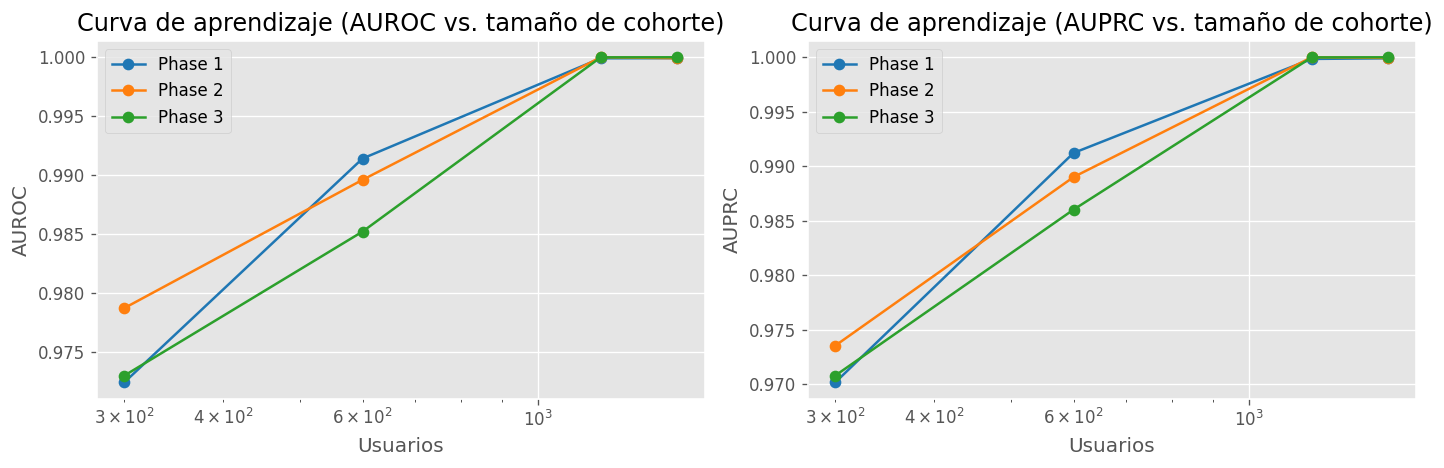

In [9]:
# ============================
# Visualización multi-cohorte
# ============================
# Leer el JSON (por si se modificó en el bucle)
data = json.loads(summary_path.read_text())
data = sorted(data, key=lambda x: x.get('cohort_users', 0))

sizes   = [d.get('cohort_users', np.nan) for d in data]
p1_auroc = [d.get('phase1', {}).get('auroc', np.nan) for d in data]
p2_auroc = [d.get('phase2', {}).get('auroc', np.nan) for d in data]
p3_auroc = [d.get('phase3', {}).get('auroc', np.nan) for d in data]  # evita KeyError
p1_auprc = [d.get('phase1', {}).get('auprc', np.nan) for d in data]
p2_auprc = [d.get('phase2', {}).get('auprc', np.nan) for d in data]
p3_auprc = [d.get('phase3', {}).get('auprc', np.nan) for d in data]

fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)

# AUROC
ax[0].plot(sizes, p1_auroc, marker='o', label='Phase 1', color='#1f77b4')
ax[0].plot(sizes, p2_auroc, marker='o', label='Phase 2', color='#ff7f0e')
ax[0].plot(sizes, p3_auroc, marker='o', label='Phase 3', color='#2ca02c')
ax[0].set_title('Curva de aprendizaje (AUROC vs. tamaño de cohorte)')
ax[0].set_xlabel('Usuarios'); ax[0].set_ylabel('AUROC'); ax[0].set_xscale('log'); ax[0].legend()

# AUPRC
ax[1].plot(sizes, p1_auprc, marker='o', label='Phase 1', color='#1f77b4')
ax[1].plot(sizes, p2_auprc, marker='o', label='Phase 2', color='#ff7f0e')
ax[1].plot(sizes, p3_auprc, marker='o', label='Phase 3', color='#2ca02c')
ax[1].set_title('Curva de aprendizaje (AUPRC vs. tamaño de cohorte)')
ax[1].set_xlabel('Usuarios'); ax[1].set_ylabel('AUPRC'); ax[1].set_xscale('log'); ax[1].legend()

plt.tight_layout(); plt.show()

# ============================
# (Opcional) Curvas por época por cohorte
# ============================
def plot_epoch_curves_for_cohort(hist, cohort_tag):
    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)
    # AUROC
    ax[0].plot([h['epoch'] for h in hist['p1']], [h['auroc'] for h in hist['p1']], label='P1', marker='o')
    ax[0].plot([h['epoch'] for h in hist['p2']], [h['auroc'] for h in hist['p2']], label='P2', marker='o')
    ax[0].plot([h['epoch'] for h in hist['p3']], [h['auroc'] for h in hist['p3']], label='P3', marker='o')
    ax[0].set_title(f'AUROC por época (cohorte {cohort_tag})'); ax[0].set_xlabel('Época'); ax[0].set_ylabel('AUROC'); ax[0].legend()
    # AUPRC
    ax[1].plot([h['epoch'] for h in hist['p1']], [h['auprc'] for h in hist['p1']], label='P1', marker='o')
    ax[1].plot([h['epoch'] for h in hist['p2']], [h['auprc'] for h in hist['p2']], label='P2', marker='o')
    ax[1].set_title(f'AUPRC por época (cohorte {cohort_tag})'); ax[1].set_xlabel('Época'); ax[1].set_ylabel('AUPRC'); ax[1].legend()
    plt.tight_layout(); plt.show()

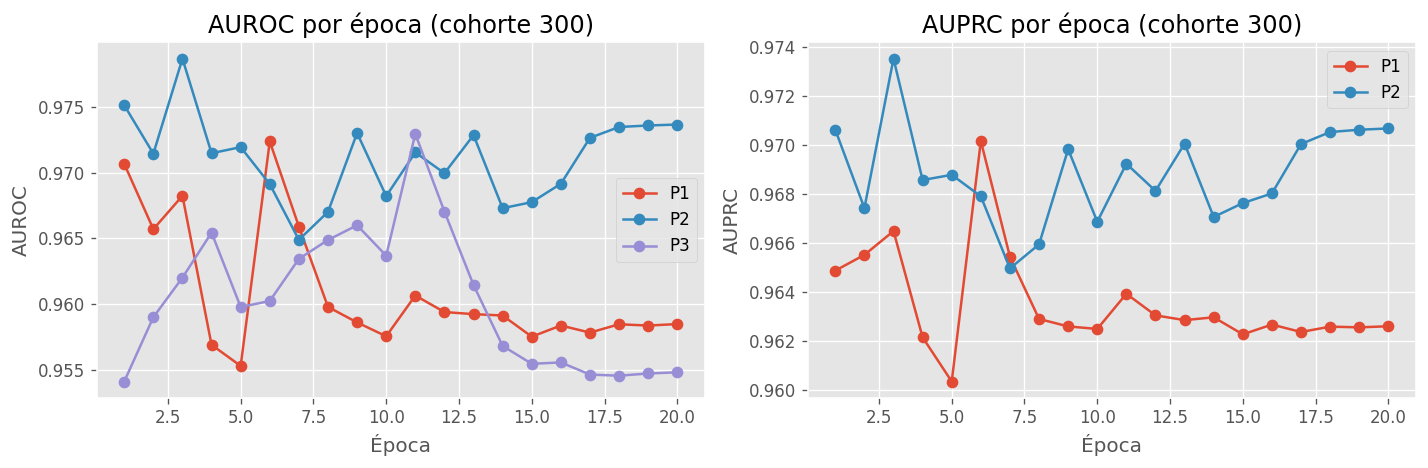

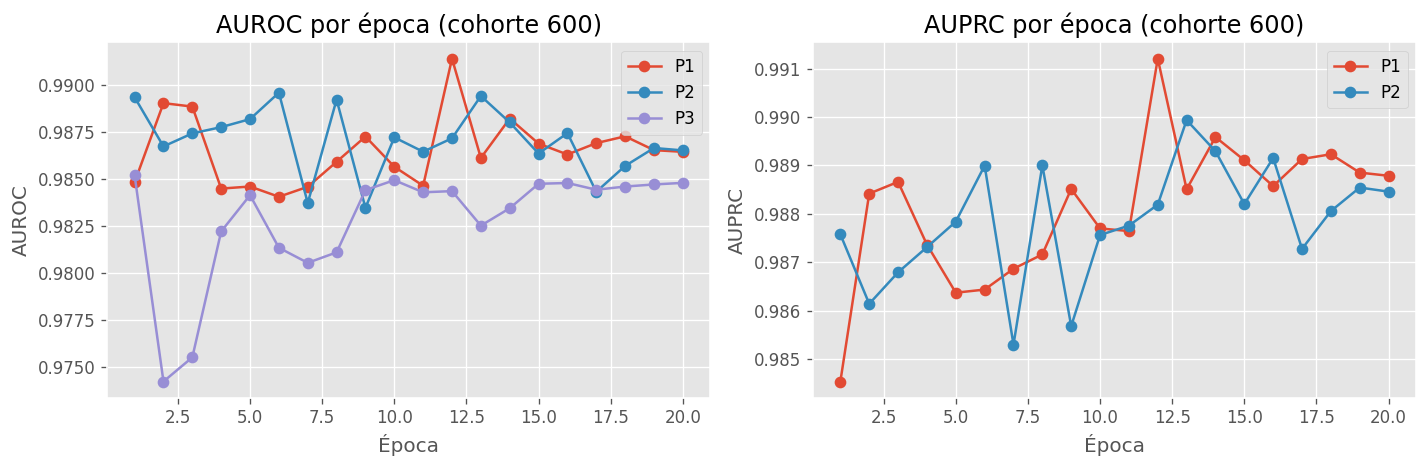

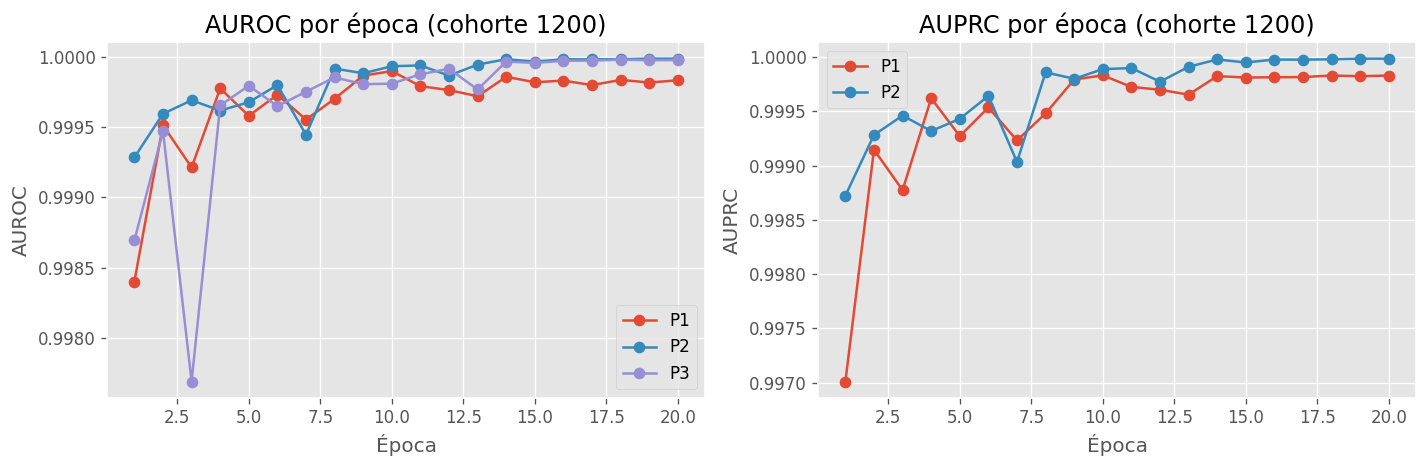

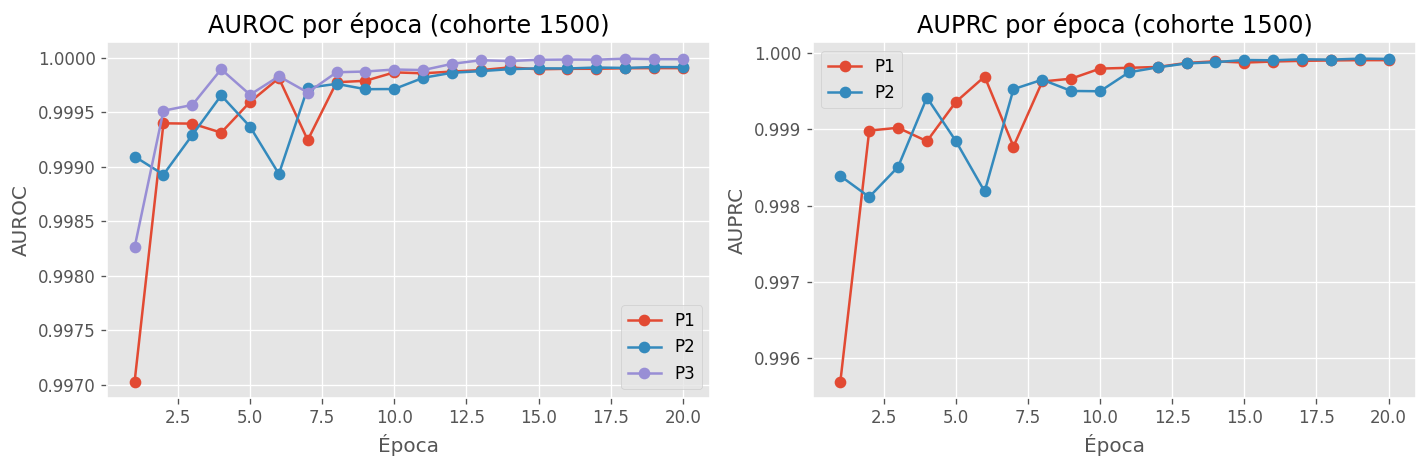

In [11]:
# Llamar si quieres ver por cohorte:
for cohort, hist in all_histories.items():
     plot_epoch_curves_for_cohort(hist, cohort)


==== Procesando cohorte 300 ====
[P1] Epoch 01 | AUROC 0.9673 | AUPRC 0.9643
[P1] Epoch 02 | AUROC 0.9693 | AUPRC 0.9675
[P1] Epoch 03 | AUROC 0.9546 | AUPRC 0.9604
[P1] Epoch 04 | AUROC 0.9575 | AUPRC 0.9620
[P1] Epoch 05 | AUROC 0.9627 | AUPRC 0.9652
[P1] Epoch 06 | AUROC 0.9511 | AUPRC 0.9602
[P1] Epoch 07 | AUROC 0.9573 | AUPRC 0.9631
[P1] Epoch 08 | AUROC 0.9559 | AUPRC 0.9624
[P1] Epoch 09 | AUROC 0.9590 | AUPRC 0.9642
[P1] Epoch 10 | AUROC 0.9619 | AUPRC 0.9650
[P1] Epoch 11 | AUROC 0.9633 | AUPRC 0.9657
[P1] Epoch 12 | AUROC 0.9621 | AUPRC 0.9654
[P1] Epoch 13 | AUROC 0.9612 | AUPRC 0.9646
[P1] Epoch 14 | AUROC 0.9597 | AUPRC 0.9643
[P1] Epoch 15 | AUROC 0.9588 | AUPRC 0.9641
[P1] Epoch 16 | AUROC 0.9582 | AUPRC 0.9639
[P1] Epoch 17 | AUROC 0.9585 | AUPRC 0.9640
[P1] Epoch 18 | AUROC 0.9574 | AUPRC 0.9636
[P1] Epoch 19 | AUROC 0.9573 | AUPRC 0.9635
[P1] Epoch 20 | AUROC 0.9572 | AUPRC 0.9634
[P2] Epoch 01 | AUROC 0.9680 | AUPRC 0.9659
[P2] Epoch 02 | AUROC 0.9470 | AUPRC 0.954

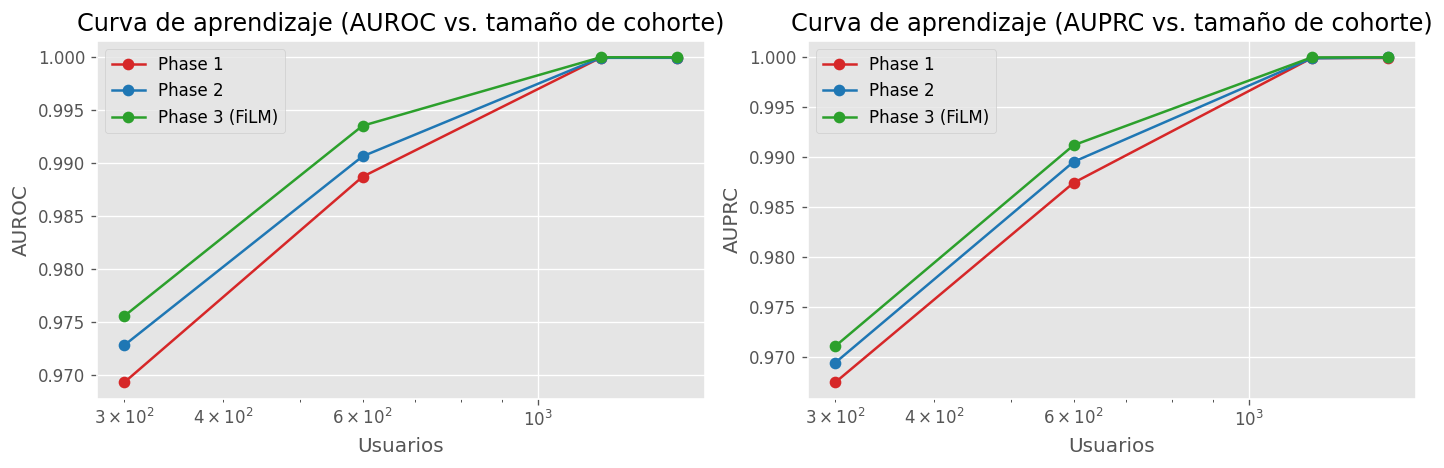

In [19]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from datetime import timedelta

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ============================
# Configuración
# ============================
BASE_DIR = Path('/home/gmartinez/Tesis/Datasets/Synthetic-data')
OUTPUTS_DIR = BASE_DIR / 'outputs'  # subcarpetas: 300, 600, 1200, 1500
COHORTS = ['300', '600', '1200', '1500']
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=SEED):
    import random
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# ============================
# Modelo: mTAN + FiLM para Fase 3
# ============================
class TimeAwareAttention(nn.Module):
    def __init__(self, d_in, d_model, n_heads=4, dropout=0.2):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dk = d_model // n_heads
        assert d_model % n_heads == 0
        self.Wq = nn.Linear(d_in, d_model)
        self.Wk = nn.Linear(d_in, d_model)
        self.Wv = nn.Linear(d_in, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.time_decay = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, T, M):
        B, L, Cin = X.shape
        Q = self.Wq(X); K = self.Wk(X); V = self.Wv(X)
        def split(Z): return Z.view(B, L, self.n_heads, self.dk).transpose(1,2)
        Qh, Kh, Vh = split(Q), split(K), split(V)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / (self.dk ** 0.5)
        # Penalización temporal
        Ti = T.unsqueeze(1).unsqueeze(-1); Tj = T.unsqueeze(1).unsqueeze(-2)
        dist = torch.abs(Ti - Tj)
        scores = scores - self.time_decay.abs() * dist
        # Máscara temporal (pasos sin observación en K)
        time_mask = (M.sum(dim=-1) > 0).unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(~time_mask, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        Z = torch.matmul(attn, Vh)
        Z = Z.transpose(1,2).contiguous().view(B, L, self.d_model)
        return self.out(Z), attn

class FiLMGenerator(nn.Module):
    def __init__(self, p_dim, d_model, n_layers, hidden=64, dropout=0.1):
        super().__init__()
        self.n_layers = n_layers
        out_dim = n_layers * d_model * 2  # gamma y beta por capa
        self.mlp = nn.Sequential(
            nn.Linear(p_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, p):
        B = p.shape[0]
        out = self.mlp(p).view(B, self.n_layers, 2, -1)  # (B, L, 2, d_model)
        gamma = out[:, :, 0, :]
        beta  = out[:, :, 1, :]
        return gamma, beta

class MTANBackboneFiLM(nn.Module):
    """
    Backbone mTAN que puede ser modulado por FiLM con el perfil (cond).
    Si cond=None, actúa como backbone normal (sin FiLM).
    """
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2, dropout=0.2, p_dim=None, film_hidden=64):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.input_proj = nn.Linear(c_in, d_model)
        self.layers = nn.ModuleList([
            nn.ModuleList([
                TimeAwareAttention(d_model, d_model, n_heads=n_heads, dropout=dropout),
                nn.LayerNorm(d_model),
                nn.Sequential(
                    nn.Linear(d_model, d_model*2),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model*2, d_model)
                ),
                nn.LayerNorm(d_model),
            ]) for _ in range(n_layers)
        ])
        self.use_film = p_dim is not None
        if self.use_film:
            self.film = FiLMGenerator(p_dim=p_dim, d_model=d_model, n_layers=n_layers, hidden=film_hidden, dropout=0.1)

    def forward(self, X, T, M, cond=None):
        x = self.input_proj(X)
        gamma = beta = None
        if self.use_film and cond is not None:
            gamma, beta = self.film(cond)  # (B, n_layers, d_model)
        for li, (attn, ln1, ff, ln2) in enumerate(self.layers):
            h, _ = attn(x, T, M)
            x = ln1(x + h)
            if gamma is not None:
                g = gamma[:, li, :].unsqueeze(1)
                b = beta[:,  li, :].unsqueeze(1)
                x = g * x + b
            f = ff(x)
            x = ln2(x + f)
            if gamma is not None:
                g = gamma[:, li, :].unsqueeze(1)
                b = beta[:,  li, :].unsqueeze(1)
                x = g * x + b
        # Pooling temporal enmascarado
        time_mask = (M.sum(dim=-1) > 0).float()
        masked_x = x * time_mask.unsqueeze(-1)
        denom = time_mask.sum(dim=1, keepdim=True).clamp_min(1.0)
        pooled = masked_x.sum(dim=1) / denom
        return pooled

class TSOnlyHead(nn.Module):
    def __init__(self, d_model=128, dropout=0.2):
        super().__init__()
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )
    def forward(self, h): return self.cls(h).squeeze(-1)

class ProfileMLP(nn.Module):
    def __init__(self, p_dim, d_hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(p_dim, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout)
        )
    def forward(self, p): return self.net(p)

class TSPlusProfileHead(nn.Module):
    def __init__(self, d_model=128, p_hidden=64, d_joint=128, dropout=0.2):
        super().__init__()
        self.joint = nn.Sequential(
            nn.Linear(d_model + p_hidden, d_joint),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_joint, 1)
        )
    def forward(self, h_mtan, h_prof):
        return self.joint(torch.cat([h_mtan, h_prof], dim=-1)).squeeze(-1)

class MTANWithFiLMHeads(nn.Module):
    """
    - Fase 1: TS only (backbone sin FiLM).
    - Fase 2: TS + perfil por concatenación post-backbone.
    - Fase 3: TS con FiLM condicionado por perfil (perfil modula el backbone).
    """
    def __init__(self, c_in, d_model=128, n_heads=4, n_layers=2,
                 p_dim=None, prof_hidden=64, film_hidden=64, dropout=0.2):
        super().__init__()
        # Backbones
        self.backbone_plain = MTANBackboneFiLM(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, p_dim=None)
        self.backbone_film  = MTANBackboneFiLM(c_in=c_in, d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, p_dim=p_dim, film_hidden=film_hidden)
        # Heads
        self.ts_head = TSOnlyHead(d_model=d_model, dropout=dropout)
        self.use_profile = p_dim is not None
        if self.use_profile:
            self.prof_mlp = ProfileMLP(p_dim=p_dim, d_hidden=prof_hidden, dropout=0.1)
            self.ts_p_head = TSPlusProfileHead(d_model=d_model, p_hidden=prof_hidden, d_joint=d_model, dropout=dropout)

    def forward_phase1(self, X, T, M):
        h = self.backbone_plain(X, T, M, cond=None)
        return self.ts_head(h)

    def forward_phase2(self, X, T, M, p):
        h = self.backbone_plain(X, T, M, cond=None)
        h_p = self.prof_mlp(p)
        return self.ts_p_head(h, h_p)

    def forward_phase3(self, X, T, M, p):
        # FiLM: el perfil (sin MLP) condiciona el backbone
        h = self.backbone_film(X, T, M, cond=p)
        return self.ts_head(h)

# ============================
# Datasets
# ============================
class TimeDataset(Dataset):
    def __init__(self, X, T, M, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.y[idx]

class TimeDatasetWithProfile(Dataset):
    def __init__(self, X, T, M, P, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.P = torch.tensor(P, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.T[idx], self.M[idx], self.P[idx], self.y[idx]

# ============================
# Utilidades de datos
# ============================
SLEEP_FEATURES = [
    'total_hours','deep_minutes','rem_minutes','awake_minutes',
    'sleep_latency_minutes','awakenings','failure_minutes'
]

def extract_hr_window(hr_daily_user, night_date, past_days=7, include_night=True, feature='hr_count'):
    L = past_days + (1 if include_night else 0)
    start_date = night_date - timedelta(days=past_days)
    end_date = night_date if include_night else (night_date - timedelta(days=1))
    idx_days = pd.date_range(start=start_date, end=end_date, freq='D')
    ser = (
        pd.DataFrame({'date': idx_days})
        .merge(hr_daily_user[['date', feature]], on='date', how='left')
        [feature].to_numpy(dtype=float)
    )
    if len(ser) != L:
        ser = np.resize(ser, L)
    return ser

def extract_sleep_features_for_night(sleep_user, night_date):
    row = sleep_user.loc[sleep_user['night_date'] == night_date, SLEEP_FEATURES]
    if row.empty:
        return np.array([np.nan]*len(SLEEP_FEATURES), dtype=float)
    return row.iloc[0].astype(float).to_numpy()

def build_samples(hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'):
    hr_by_user = {u: df.sort_values('date') for u, df in hr_daily.groupby('user_id')}
    sleep_by_user = {u: df.sort_values('night_date') for u, df in sleep_data.groupby('user_id')}
    X_list, T_list, M_list, y_list, meta_list, night_feat_list = [], [], [], [], [], []
    for _, row in nights.iterrows():
        u = row['user_id']; night = row['night_date']; target = row['target']
        hr_user = hr_by_user.get(u, pd.DataFrame(columns=['date',use_hr_feature]))
        sleep_user = sleep_by_user.get(u, pd.DataFrame(columns=['night_date'] + SLEEP_FEATURES))
        hr_vec = extract_hr_window(hr_user, night_date=night, past_days=past_days, include_night=True, feature=use_hr_feature)
        L1 = len(hr_vec)
        t_hr = np.linspace(0.0, 1.0, L1); m_hr = (~np.isnan(hr_vec)).astype(float)
        s_vec = extract_sleep_features_for_night(sleep_user, night)
        t_sl = np.array([1.0]); m_sl = (~np.isnan(s_vec)).astype(float)
        # ensamblar secuencia
        t_seq = np.concatenate([t_hr, t_sl], axis=0)
        C = 1 + len(SLEEP_FEATURES)
        X = np.zeros((L1+1, C), dtype=float)
        M = np.zeros((L1+1, C), dtype=float)
        X[:L1, 0] = hr_vec; M[:L1, 0] = m_hr
        X[L1, 1:] = s_vec;  M[L1, 1:] = m_sl
        X_list.append(X); T_list.append(t_seq); M_list.append(M)
        y_list.append(target); meta_list.append((u, night)); night_feat_list.append(s_vec)
    return X_list, T_list, M_list, np.array(y_list, dtype=int), meta_list, np.vstack(night_feat_list)

def stack_fixed_length(X_list, T_list, M_list):
    return np.stack(X_list, axis=0), np.stack(T_list, axis=0), np.stack(M_list, axis=0)

def standardize_by_train(X_all, M_all, train_idx):
    obs_mask = M_all[train_idx].astype(bool)
    sum_x = np.nansum(np.where(obs_mask, X_all[train_idx], np.nan), axis=(0,1))
    count_x = obs_mask.sum(axis=(0,1)).clip(min=1)
    mean_x = sum_x / count_x
    sum_sq = np.nansum((np.where(obs_mask, X_all[train_idx], mean_x) - mean_x)**2, axis=(0,1))
    var_x = sum_sq / count_x
    std_x = np.sqrt(np.maximum(var_x, 1e-8))
    def apply(X, M):
        Xz = (np.where(M>0, X, mean_x) - mean_x) / std_x
        return np.where(M>0, Xz, 0.0)
    return apply

# Perfiles
CAT_COLS = ['age_group','gender','physical_activity_level','smoking_status','alcohol_consumption','diabetes','hypertension']
NUM_COLS = ['age']

def fit_profile_artifacts(df_train):
    cat_maps = {}
    for c in CAT_COLS:
        cats = list(pd.Series(df_train[c].astype(str)).astype('category').cat.categories)
        if "<UNK>" not in cats: cats += ["<UNK>"]
        cat_maps[c] = cats
    num_stats = {}
    for c in NUM_COLS:
        col = pd.to_numeric(df_train[c], errors='coerce')
        mu = float(col.mean(skipna=True)) if col.notna().any() else 0.0
        sd = float(col.std(skipna=True)) if col.notna().any() else 1.0
        if sd < 1e-8: sd = 1.0
        num_stats[c] = {"mean": mu, "std": sd}
    return cat_maps, num_stats

def one_hot_series(series, categories):
    cat_to_idx = {cat:i for i,cat in enumerate(categories)}
    unk = cat_to_idx.get("<UNK>")
    idx = [cat_to_idx.get(str(v), unk) for v in series.fillna("<UNK>").astype(str)]
    return np.eye(len(categories), dtype=np.float32)[np.array(idx, dtype=int)]

def zscore_series(series, mean, std):
    x = pd.to_numeric(series, errors='coerce').fillna(mean).to_numpy(dtype=np.float32)
    return ((x - mean) / std).astype(np.float32)

def build_profile_matrix(df, cat_maps, num_stats):
    parts = []
    for c in NUM_COLS:
        parts.append(zscore_series(df[c], num_stats[c]['mean'], num_stats[c]['std']).reshape(-1,1))
    for c in CAT_COLS:
        parts.append(one_hot_series(df[c], cat_maps[c]))
    pres = np.ones((df.shape[0],1), dtype=np.float32)
    parts.append(pres)
    P = np.concatenate(parts, axis=1).astype(np.float32)
    return P

# ============================
# Evaluación y entrenamiento
# ============================
def evaluate_p1(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, yb in loader:
            prob = torch.sigmoid(model.forward_phase1(Xb.to(device), Tb.to(device), Mb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p2(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase2(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def evaluate_p3_film(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for Xb, Tb, Mb, Pb, yb in loader:
            prob = torch.sigmoid(model.forward_phase3(Xb.to(device), Tb.to(device), Mb.to(device), Pb.to(device)))
            ys.append(yb.numpy()); ps.append(prob.detach().cpu().numpy())
    y_true = np.concatenate(ys); y_prob = np.concatenate(ps)
    return (
        roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    )

def train_loop(model, loader, eval_fn, epochs=20, lr=2e-3, wd=1e-4, phase_tag='P'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best = {'auroc': -1, 'state': None}; history = []
    for ep in range(1, epochs+1):
        model.train()
        for batch in loader:
            optimizer.zero_grad()
            if phase_tag == 'P1':
                Xb, Tb, Mb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase1(Xb, Tb, Mb)
            elif phase_tag == 'P2':
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase2(Xb, Tb, Mb, Pb)
            else:  # P3 (FiLM)
                Xb, Tb, Mb, Pb, yb = [t.to(device) for t in batch]
                logit = model.forward_phase3(Xb, Tb, Mb, Pb)
            loss = criterion(logit, yb); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()
        auroc, auprc = eval_fn(model)
        history.append({'epoch': ep, 'auroc': auroc, 'auprc': auprc})
        if auroc > best['auroc']:
            best['auroc'] = auroc
            best['state'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"[{phase_tag}] Epoch {ep:02d} | AUROC {auroc:.4f} | AUPRC {auprc:.4f}")
    if best['state'] is not None:
        model.load_state_dict(best['state'])
    return model, history, best['auroc']

# ============================
# Bucle multi-cohorte
# ============================
summary_path = OUTPUTS_DIR / "phase_results_summary.json"
# Opcional: descomenta para recomputar desde cero
# if summary_path.exists(): summary_path.unlink()
try:
    summary = json.loads(summary_path.read_text())
except Exception:
    summary = []

all_histories = {}  # para curvas por época por cohorte

for cohort in COHORTS:
    print(f"\n==== Procesando cohorte {cohort} ====")
    data_dir = OUTPUTS_DIR / cohort
    hr_csv = data_dir / "hr_series.csv"
    sleep_csv = data_dir / "sleep_series.csv"
    labels_csv = data_dir / "nightly_labeled.csv"
    profiles_csv = data_dir / "user_profiles.csv"

    # Validación rápida
    for p in [hr_csv, sleep_csv, labels_csv, profiles_csv]:
        if not p.exists():
            print(f"Saltando cohorte {cohort}: falta {p.name}")
            break
    else:
        # Cargar
        hr_data = pd.read_csv(hr_csv, parse_dates=['timestamp'])
        sleep_data = pd.read_csv(sleep_csv, parse_dates=['night_date'])
        labels = pd.read_csv(labels_csv, parse_dates=['night_date'])
        profiles_df = pd.read_csv(profiles_csv)

        for df in (hr_data, sleep_data, labels, profiles_df):
            if 'user_id' in df.columns:
                df['user_id'] = df['user_id'].astype(str)

        # Serie diaria
        hr_data['date'] = hr_data['timestamp'].dt.floor('D')
        hr_daily = (
            hr_data
            .groupby(['user_id','date'], as_index=False)
            .agg(hr_count=('hr','count'),
                 hr_med=('hr','median'))
        )

        # Etiquetas
        label_map = {'Adequate Recovery': 1, 'Deficient Recovery': 0}
        labels['target'] = labels['recovery_label_binary'].map(label_map).astype(int)
        nights = labels[['user_id','night_date','target']].dropna().copy()
        nights['night_date'] = pd.to_datetime(nights['night_date'])

        # Asegurar columnas de sueño
        for col in SLEEP_FEATURES:
            if col not in sleep_data.columns:
                sleep_data[col] = np.nan

        # Construir muestras
        X_list, T_list, M_list, y, meta, night_feats = build_samples(
            hr_daily, sleep_data, nights, past_days=7, use_hr_feature='hr_count'
        )
        X_all, T_all, M_all = stack_fixed_length(X_list, T_list, M_list)

        # Split por usuario
        users = np.array([u for u, _ in meta]).astype(str)
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        train_idx, test_idx = next(gss.split(np.zeros(len(users)), groups=users))

        # Estandarizar
        apply_std = standardize_by_train(X_all, M_all, train_idx)
        X_std = apply_std(X_all, M_all)
        X_train, T_train, M_train, y_train = X_std[train_idx], T_all[train_idx], M_all[train_idx], y[train_idx]
        X_test,  T_test,  M_test,  y_test  = X_std[test_idx],  T_all[test_idx],  M_all[test_idx],  y[test_idx]

        # Perfiles
        train_users = sorted(set(users[train_idx]))
        test_users  = sorted(set(users[test_idx]))
        df_prof_train = profiles_df[profiles_df['user_id'].isin(train_users)].copy()
        df_prof_test  = profiles_df[profiles_df['user_id'].isin(test_users)].copy()
        cat_maps, num_stats = fit_profile_artifacts(df_prof_train)
        P_train = build_profile_matrix(df_prof_train, cat_maps, num_stats)
        P_test  = build_profile_matrix(df_prof_test,  cat_maps, num_stats)

        prof_by_user_train = {u: v for u, v in zip(df_prof_train['user_id'].astype(str), list(P_train))}
        prof_by_user_test  = {u: v for u, v in zip(df_prof_test['user_id'].astype(str),  list(P_test))}
        p_dim = P_train.shape[1]

        def build_sample_profiles(meta, train_split_users, prof_train, prof_test, p_dim):
            profiles = []
            for (u, _night) in meta:
                u = str(u)
                vec = prof_train.get(u) if (u in train_split_users) else prof_test.get(u)
                if vec is None:
                    v = np.zeros((p_dim,), dtype=np.float32); v[-1] = 0.0
                    vec = v
                profiles.append(vec.astype(np.float32))
            return np.stack(profiles).astype(np.float32)

        train_split_users_set = set(train_users)
        profiles_all = build_sample_profiles(meta, train_split_users_set, prof_by_user_train, prof_by_user_test, p_dim)
        profiles_train = profiles_all[train_idx]; profiles_test = profiles_all[test_idx]

        # Loaders
        train_loader_p1 = DataLoader(TimeDataset(X_train, T_train, M_train, y_train), batch_size=128, shuffle=True)
        test_loader_p1  = DataLoader(TimeDataset(X_test,  T_test,  M_test,  y_test),  batch_size=256, shuffle=False)

        train_loader_p2 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True)
        test_loader_p2  = DataLoader(TimeDatasetWithProfile(X_test,  T_test,  M_test,  profiles_test,  y_test),  batch_size=256, shuffle=False)

        # Para P3 (FiLM) se usa también TimeDatasetWithProfile (no night features)
        train_loader_p3 = DataLoader(TimeDatasetWithProfile(X_train, T_train, M_train, profiles_train, y_train), batch_size=128, shuffle=True)
        test_loader_p3  = DataLoader(TimeDatasetWithProfile(X_test,  T_test,  M_test,  profiles_test,  y_test),  batch_size=256, shuffle=False)

        # Modelos y entrenamiento por fase
        EPOCHS = 20
        c_in = X_train.shape[2]

        # Fase 1
        set_seed(SEED)
        model_p1 = MTANWithFiLMHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                                     p_dim=None, dropout=0.2).to(device)
        model_p1, hist_p1, _ = train_loop(model_p1, train_loader_p1,
                                          lambda m: evaluate_p1(m, test_loader_p1),
                                          epochs=EPOCHS, phase_tag='P1')
        auroc_p1, auprc_p1 = evaluate_p1(model_p1, test_loader_p1)

        # Fase 2
        set_seed(SEED)
        model_p2 = MTANWithFiLMHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                                     p_dim=p_dim, dropout=0.2).to(device)
        model_p2, hist_p2, _ = train_loop(model_p2, train_loader_p2,
                                          lambda m: evaluate_p2(m, test_loader_p2),
                                          epochs=EPOCHS, phase_tag='P2')
        auroc_p2, auprc_p2 = evaluate_p2(model_p2, test_loader_p2)

        # Fase 3 (FiLM)
        set_seed(SEED)
        model_p3 = MTANWithFiLMHeads(c_in=c_in, d_model=128, n_heads=4, n_layers=2,
                                     p_dim=p_dim, dropout=0.2).to(device)
        model_p3, hist_p3, _ = train_loop(model_p3, train_loader_p3,
                                          lambda m: evaluate_p3_film(m, test_loader_p3),
                                          epochs=EPOCHS, phase_tag='P3')
        auroc_p3, auprc_p3 = evaluate_p3_film(model_p3, test_loader_p3)

        # Guardar resumen acumulado
        item = {
            "cohort_users": int(cohort),
            "phase1": {"auroc": float(auroc_p1), "auprc": float(auprc_p1)},
            "phase2": {"auroc": float(auroc_p2), "auprc": float(auprc_p2)},
            "phase3": {"auroc": float(auroc_p3), "auprc": float(auprc_p3)}  # FiLM
        }
        summary.append(item)
        summary_path.write_text(json.dumps(summary, indent=2))

        # Historias por época (para gráficas por cohorte)
        all_histories[cohort] = {"p1": hist_p1, "p2": hist_p2, "p3": hist_p3}

# ============================
# Visualización: Curvas de aprendizaje multi-cohorte
# ============================
data = json.loads(summary_path.read_text())
data = sorted(data, key=lambda x: x.get('cohort_users', 0))
sizes = [d.get('cohort_users', np.nan) for d in data]

p1_auroc = [d.get('phase1', {}).get('auroc', np.nan) for d in data]
p2_auroc = [d.get('phase2', {}).get('auroc', np.nan) for d in data]
p3_auroc = [d.get('phase3', {}).get('auroc', np.nan) for d in data]

p1_auprc = [d.get('phase1', {}).get('auprc', np.nan) for d in data]
p2_auprc = [d.get('phase2', {}).get('auprc', np.nan) for d in data]
p3_auprc = [d.get('phase3', {}).get('auprc', np.nan) for d in data]

fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)

# AUROC
ax[0].plot(sizes, p1_auroc, marker='o', label='Phase 1', color='#d62728')
ax[0].plot(sizes, p2_auroc, marker='o', label='Phase 2', color='#1f77b4')
ax[0].plot(sizes, p3_auroc, marker='o', label='Phase 3 (FiLM)', color='#2ca02c')
ax[0].set_title('Curva de aprendizaje (AUROC vs. tamaño de cohorte)')
ax[0].set_xlabel('Usuarios'); ax[0].set_ylabel('AUROC'); ax[0].set_xscale('log'); ax[0].legend()

# AUPRC
ax[1].plot(sizes, p1_auprc, marker='o', label='Phase 1', color='#d62728')
ax[1].plot(sizes, p2_auprc, marker='o', label='Phase 2', color='#1f77b4')
ax[1].plot(sizes, p3_auprc, marker='o', label='Phase 3 (FiLM)', color='#2ca02c')
ax[1].set_title('Curva de aprendizaje (AUPRC vs. tamaño de cohorte)')
ax[1].set_xlabel('Usuarios'); ax[1].set_ylabel('AUPRC'); ax[1].set_xscale('log'); ax[1].legend()

plt.tight_layout(); plt.show()

# ============================
# Visualización: Curvas por época por cohorte (opcional)
# ============================
def plot_epoch_curves_for_cohort(hist, cohort_tag):
    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)

    def maybe_plot(key, label, color):
        if key in hist and len(hist[key]) > 0:
            epochs = [h['epoch'] for h in hist[key] if h.get('auroc') is not None]
            aurocs = [h['auroc'] for h in hist[key] if h.get('auroc') is not None]
            auprcs = [h['auprc'] for h in hist[key] if h.get('auprc') is not None]
            if len(epochs) > 0:
                ax[0].plot(epochs, aurocs, label=label, marker='o', color=color, alpha=0.9)
                ax[1].plot(epochs, auprcs, label=label, marker='o', color=color, alpha=0.9)

    maybe_plot('p1', 'P1', '#d62728')
    maybe_plot('p2', 'P2', '#1f77b4')
    maybe_plot('p3', 'P3 (FiLM)', '#2ca02c')

    ax[0].set_title(f'AUROC por época (cohorte {cohort_tag})')
    ax[0].set_xlabel('Época'); ax[0].set_ylabel('AUROC'); ax[0].legend()

    ax[1].set_title(f'AUPRC por época (cohorte {cohort_tag})')
    ax[1].set_xlabel('Época'); ax[1].set_ylabel('AUPRC'); ax[1].legend()

    plt.tight_layout(); plt.show()




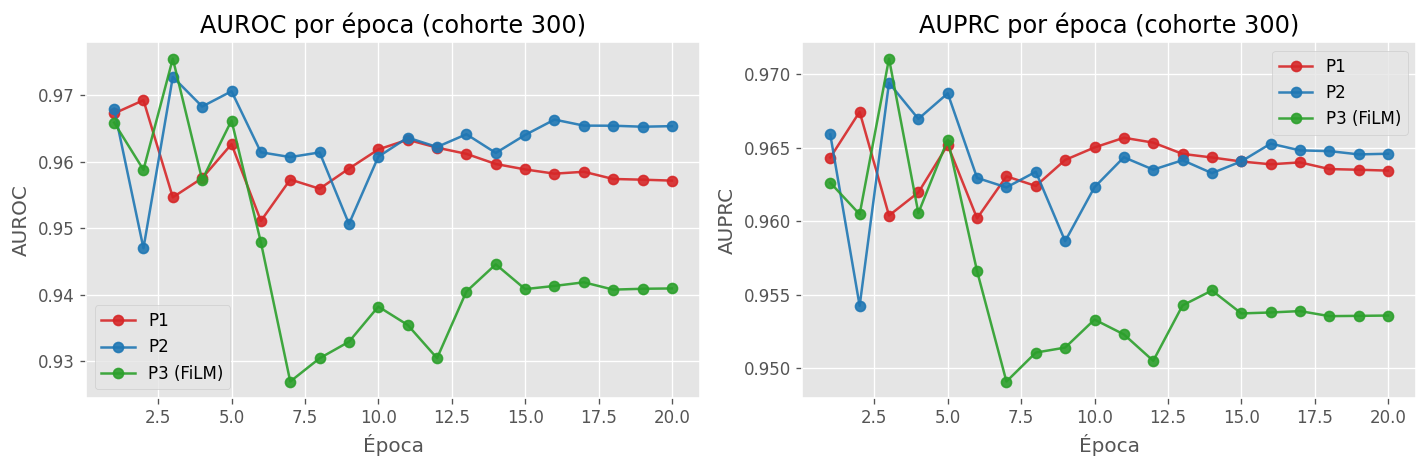

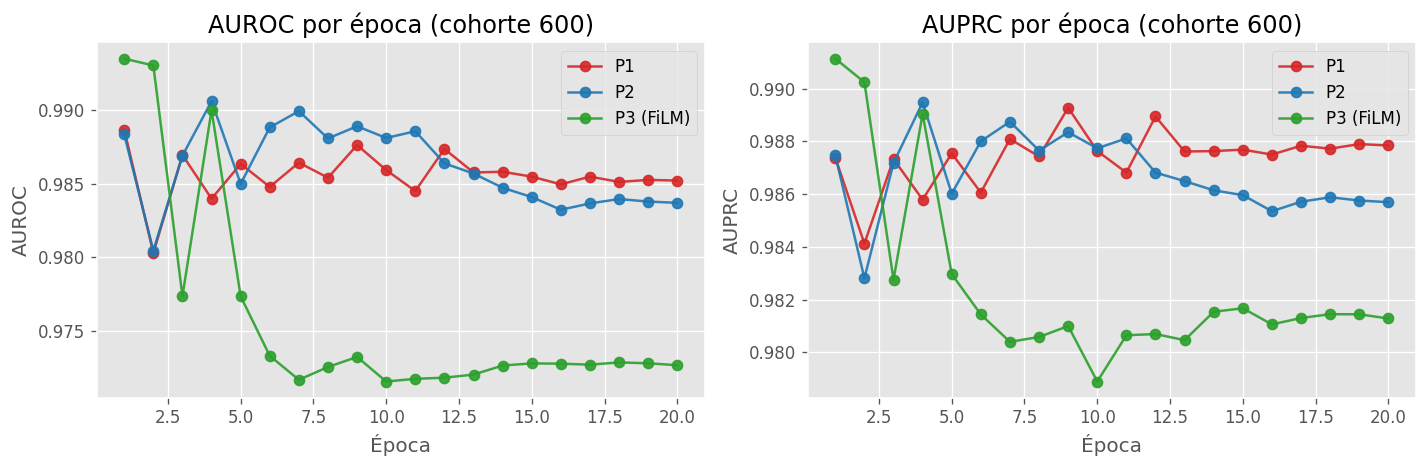

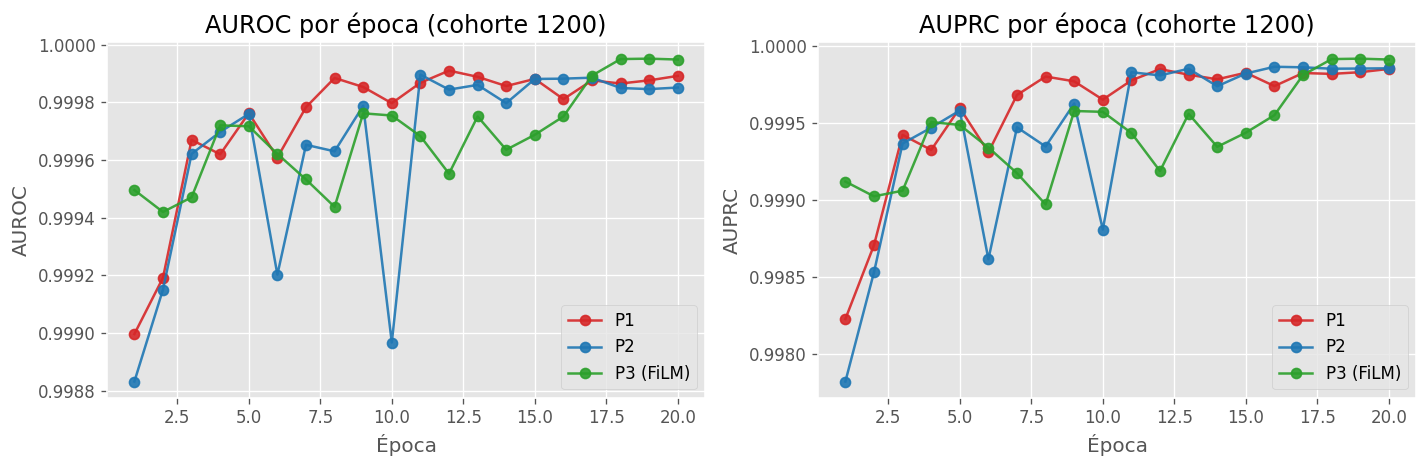

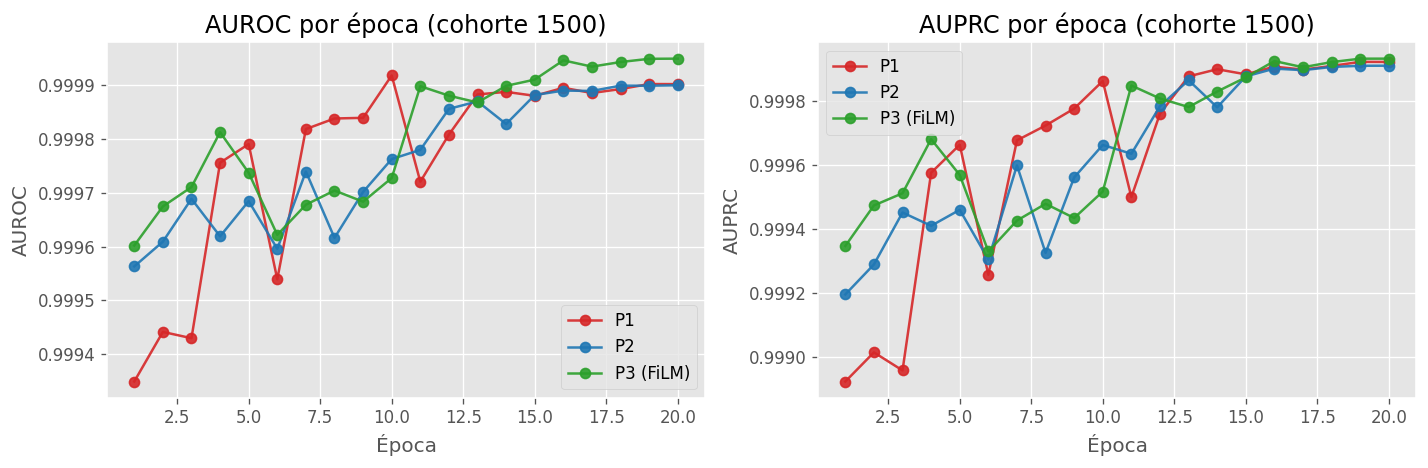

In [20]:
# Graficar por época para cada cohorte:
for cohort, hist in all_histories.items():
    plot_epoch_curves_for_cohort(hist, cohort)